In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

To do:
1. Compare results for Markov chains (**done**, same results cause of $\hat{R} < 1.1$):
    1. median and std of all chains'values (**done**)
    2. mean of all chains of the mean value (**done**)
2. In analysis.py generalize of prior's distribution parameters (**no need**)
3. modulation of active cases of 7 days (monday), try to fit weekly mean data, change beta accordingly
4. Presentation title: something like "Limits of forecasting COVID-19 data"
5. Change the burn in size, so traces plot showing the burn in one and so I have to raise the number of iterations
6. R^2 adjusted (link)[https://medium.com/analytics-vidhya/measuring-the-goodness-of-fit-r%C2%B2-versus-adjusted-r%C2%B2-1e8ed0b5784a]
7. Implement Kolmogorov Smirnov test for goodness of fit (2 samples)
8. Solve problem of first two points in recovered+death variation plot
9. Add fit until 3 week post peak for first wave
<br> Optional:
    1. Add forecasting for t_peak (**done**)
    2. Add forecasting for end of end of epidemic (confirmed cases less then 1000 for the first time) (**done**)

In [4]:
import sys
import pandas as pd 
import numpy as np
import pyjags as pj
import arviz as az
from scipy import stats
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from datetime import datetime
import seaborn as sns
from analysis import Analysis

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image 


%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

#  Analytical solution of the SCIR model at low fraction of infected individuals

The SCIR model includes the usual states of an SIR model plus a new class C for individuals
sent to confinement that are susceptible but not infected.

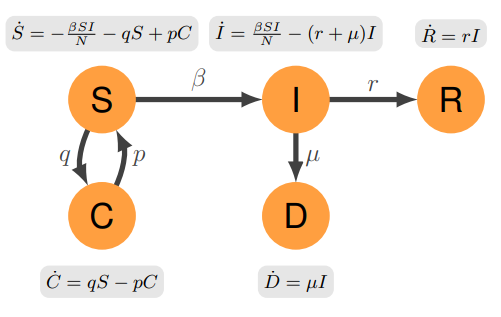

In [3]:
Image("SCIR_model.png")

Diagram of the epidemic model along with the equations ruling the dynamics. Susceptible individuals $(S)$ can enter and exit confinement $(C)$, or become infected $(I)$. Infected
individuals can recover $(R)$ or die $(D)$. $N$ is the total population. Rates for each process are
displayed in the figure, $q$ depends on specific measures restricting mobility, while $p$ stands for
individuals that leave the confinement measures (e.g. people working at essential jobs like food
supply, health care, policing) as well as for defection. We fit I to data on officially diagnosed
cases, which are automatically quarantined: the underlying assumption is that the real, mostly
undetected, number of infections is proportional to the diagnosed cases.
<br>

In a sufficiently large population, the number of infected individuals at the initial stages of the infection is well below the population size. Under certain conditions, it may stay small in
comparison to the number of susceptible individuals remaining. This seems to be the case for
several weeks of spread of COVID-19 in most countries.
If $I(t)/N \ll 1$, then the nonlinear term in the equation for the number of susceptible
individuals can be neglected. Within this approximation, the equations determining the dynamics are


$$\left\{\begin{array}
\dot \dot{S} = -qS + pC, \\
\dot{C} = qS - pC, \\
\dot{I} = \frac{\beta}{N}SI - (r+\mu)I, \\
\dot{R} = rI, \\
\dot{D} = \mu I.  \\
\end{array}\right.$$


The first two equations imply $S + C = N$, so $C = N − S$ and reformulate the equations as

$$\left\{\begin{matrix}
\dot{S} = -(q+p)S + pN, \\
\dot{I} = \frac{\beta}{N}IS - (r+\mu)I, \\
\end{matrix}\right.$$

The solution of this system can be obtained in closed form as

\begin{array}[]
SS(t) = \frac{N}{q+p}[p+qe^{-(p+q)t}], & R(t)=r\int_{0}^{t}I(u)du,\\
I(t)=I_{0}e^{[R^*_0(t)-1](r+\mu)t}, & D(t)=\mu\int_{0}^{t}I(u)du,\\
\end{array}

where
\begin{array}[]
RR^*_0(t) = \frac{R_0}{q+p}[p+q\frac{1-e^{-(p+q)t}}{(q+p)t}], & R_0=\frac{\beta}{r+\mu}\\
\end{array}

is the $\textit{effective basic reproduction number}$ modulated by the confinement, $R_0$ being its value at the beginning of the
epidemic.

## Fit a parametric Bayesian model


Simultaneously fit the number of active cases (I) and the
new number of cases in the interval ∆t = 1 day of recovered (R) and dead (D) cases in logarithmic scale—a linear scale
would give a biased larger weight to later times.
<br>

Variables:

\begin{array}[lll]
 llogI(t) \sim N(logI(t_0) + [\beta − (r + \mu)](t − t_0), \sigma_I),& t_0 < t ≤ t_q, & \mbox{(before confinement measure)}\\ 
 logI(t) \sim N(logI(t_q) + [R^*_0(t − t_q)−1](r + \mu)(t − t_q), \sigma_I),& t_q < t, & \mbox{(after confinement measure)}\\ 
 logX(t) \sim N(log(r + \mu) + logI(t), \sigma_X),& t > t_{X_{0}} &
\end{array}

where $X(t)$ = $\Delta$ $R(t)$ + $\Delta$ $D(t)$ is the change in the number of recovered plus dead cases daily reported.
Priors

\begin{array}
\beta\beta ∼ U(0,1), & 1/\sigma^2_I ∼ \Gamma(0.01,0.01), \\
r + \mu ∼ U(0,1), & 1/σ^2_X ∼ \Gamma(0.01,0.01), \\ 
p ∼ U(0,5), \\
q ∼ U(0,5)
\end{array}

where ∼ stands for distributed as, and $N$, $U$ and $Γ$ stand for Normal, Uniform and Gamma distributions. $t_0$ and $t_{X_{0}}$ stand for the days (since February 28th) where the first Infected and Recovered+Death cases were reported, respectively.
<br>
<br>
This model fit directly the solution of the deterministic model.
<br>
The priors for $\beta$ and $r + \mu$ are informative priors derived from the fact that in every country where cases of
coronavirus are detected, the doubling period at the very early stages of the epidemic was never smaller than two days.
Hence we have taken for these parameters a prior U(0,1) ($\beta < 1$). For the other parameters we assume a non-informative prior
U(0,5) (changes faster than 1/5 day are meaningless in any compartmental model).

# Dataset Spain
After the 18th of May the Spanish government stopped publishing data about recovered

In [6]:
# data until 17 may
url = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/covid-19-es.csv"
# data until 31 march
url_confirmed = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/confirmed-march31.csv"
url_recovered = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/recovered-march31.csv"
url_death = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/deaths-march31.csv"

df = pd.read_csv(url, keep_date_col=True)
df = df[~df.isna().any(axis=1)].reset_index(drop=True)
df['Day'] = pd.date_range(start="2020.01.31", end="2020.05.17")
df['Day'] = pd.to_datetime(df.Day, format='%Y-%m-%d').dt.strftime('%Y.%m.%d')

df.loc[(df.Day <= "2020.03.31") & (df.Day >= "2020.02.27"), ['Death', 'Confirmed', 'Recovered']] = np.column_stack([pd.read_csv(url_death)['Spain'],
                                                                        pd.read_csv(url_confirmed)['Spain'],
                                                                        pd.read_csv(url_recovered)['Spain']])
df['Confirmed'] = df.Confirmed - df.Recovered - df.Death
df['Confirmed_smooth'] = df.Confirmed.rolling(2, min_periods=1).mean()
df['Recovered_Death'] = (df.Recovered + df.Death).diff().fillna(0) # (daily derivative)
df['Recovered_Death_smooth'] = df.Recovered_Death.rolling(2, min_periods=1).mean()

df

Day    Death  Confirmed  Recovered  Confirmed_smooth  \
0    2020.01.31      0.0        1.0        0.0               1.0   
1    2020.02.01      0.0        1.0        0.0               1.0   
2    2020.02.02      0.0        1.0        0.0               1.0   
3    2020.02.03      0.0        1.0        0.0               1.0   
4    2020.02.04      0.0        1.0        0.0               1.0   
..          ...      ...        ...        ...               ...   
103  2020.05.13  27091.0    60777.0   140823.0           61570.0   
104  2020.05.14  27308.0    58858.0   143374.0           59817.5   
105  2020.05.15  27449.0    57951.0   144783.0           58404.5   
106  2020.05.16  27549.0    56703.0   146446.0           57327.0   
107  2020.05.17  27634.0    54140.0   149576.0           55421.5   

     Recovered_Death  Recovered_Death_smooth  
0                0.0                     0.0  
1                0.0                     0.0  
2                0.0                     0.0  
3                0.0                     0.0  
4                0.0                     0.0  
..               ...                     ...  
103           2025.0                  2019.0  
104           2768.0                  2396.5  
105           1550.0                  2159.0  
106           1763.0                  1656.5  
107           3215.0                  2489.0  

[108 rows x 7 columns]

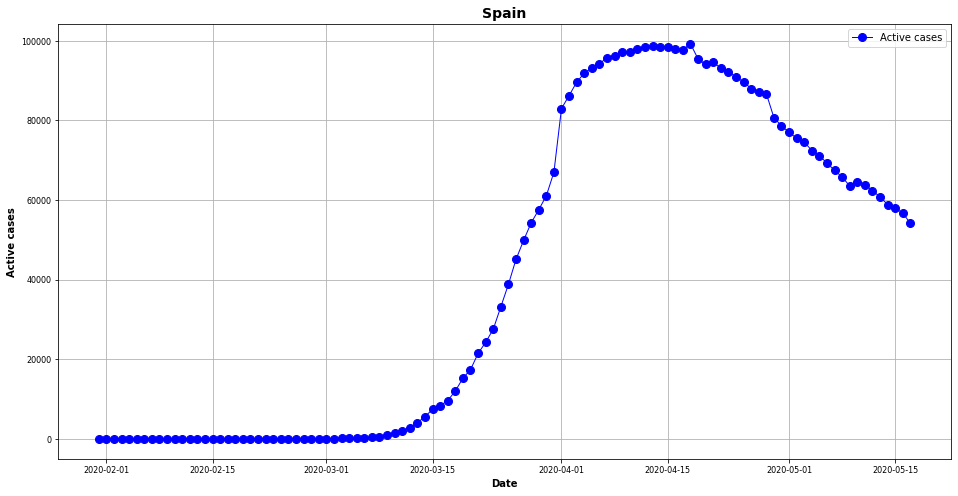

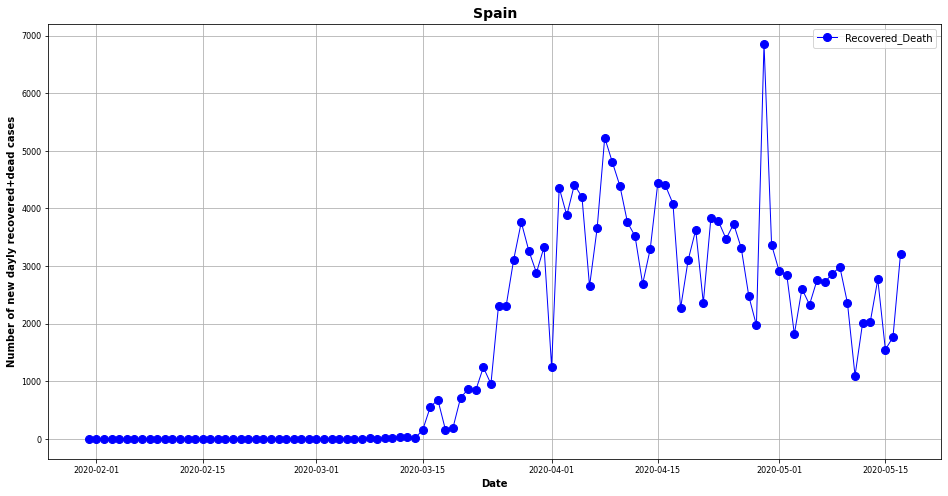

In [4]:
# save fgure with plot from january
plt.plot(pd.to_datetime(df.Day), df.Confirmed, 'bo-', lw=1, label='Active cases')
#plt.plot(pd.to_datetime(df.Day), df.Confirmed_smooth, 'r', lw=2, label='Active cases (2-days rolling average)')
#ymin, ymax = plt.ylim()
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Spain', weight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("active_cases_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df.Day), df.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
#plt.plot(pd.to_datetime(df.Day), df.Recovered_Death_smooth, 'r', lw=2, label='Recovered_Death (2-days rolling average)')
#ymin, ymax = plt.ylim()
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Spain', weight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("recovered_death_data_Spain.png", quality=100, transparent=True, dpi=400)

In [7]:
df = df[df.Day >= '2020.02.28'].reset_index(drop=True)
df

Day    Death  Confirmed  Recovered  Confirmed_smooth  \
0   2020.02.28      0.0       32.0        0.0              24.0   
1   2020.02.29      0.0       44.0        0.0              38.0   
2   2020.03.01      0.0       66.0        0.0              55.0   
3   2020.03.02      0.0      114.0        0.0              90.0   
4   2020.03.03      0.0      150.0        0.0             132.0   
..         ...      ...        ...        ...               ...   
75  2020.05.13  27091.0    60777.0   140823.0           61570.0   
76  2020.05.14  27308.0    58858.0   143374.0           59817.5   
77  2020.05.15  27449.0    57951.0   144783.0           58404.5   
78  2020.05.16  27549.0    56703.0   146446.0           57327.0   
79  2020.05.17  27634.0    54140.0   149576.0           55421.5   

    Recovered_Death  Recovered_Death_smooth  
0               0.0                    -1.5  
1               0.0                     0.0  
2               0.0                     0.0  
3               0.0                     0.0  
4               0.0                     0.0  
..              ...                     ...  
75           2025.0                  2019.0  
76           2768.0                  2396.5  
77           1550.0                  2159.0  
78           1763.0                  1656.5  
79           3215.0                  2489.0  

[80 rows x 7 columns]

## Fit ending before peak data
fit from 2020-02-27 to 2020-03-29 with confinement measure aplied on 2020-03-11

In [4]:
# instantiating an analysis object
analysis_esp = Analysis(date=df['Day'].to_numpy(),
                        confirmed=df['Confirmed'].to_numpy(),
                        recovered_death=df['Recovered_Death'].to_numpy(),
                        quarantine='2020.03.09',
                        last_data='2020.03.29',
                        last_projection='2020.05.17',
                        peak='2020.04.18',
                        beta=[0,1],
                        rmu=[0,1],
                        q=[0,5],
                        p=[0,5],
                        tauI=[0.01, 0.01],
                        tauX=[0.01, 0.01],
                        country='Spain')

In [50]:
%%time
# call sampler analysis' method
analysis_esp.sampler(nchains=12, nthreads=12, niter=10000, burn_in=0.5)

sampling: iterations 120000 of 120000, elapsed 0:00:03, remaining 0:00:00
CPU times: user 23.3 s, sys: 19.2 ms, total: 23.3 s
Wall time: 3.94 s


In [51]:
analysis_esp.summary()

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta   0.3698   0.0098    0.3551     0.3884  1.0048
rmu    0.0204   0.0075    0.0130     0.0341  1.0036
q      0.0550   0.0049    0.0478     0.0669  1.0029
p      0.0067   0.0094    0.0003     0.0347  1.0019
tauI  57.2026  16.2638   31.1559    94.4027  1.0002
tauX   0.7660   0.2303    0.3942     1.2892  1.0014

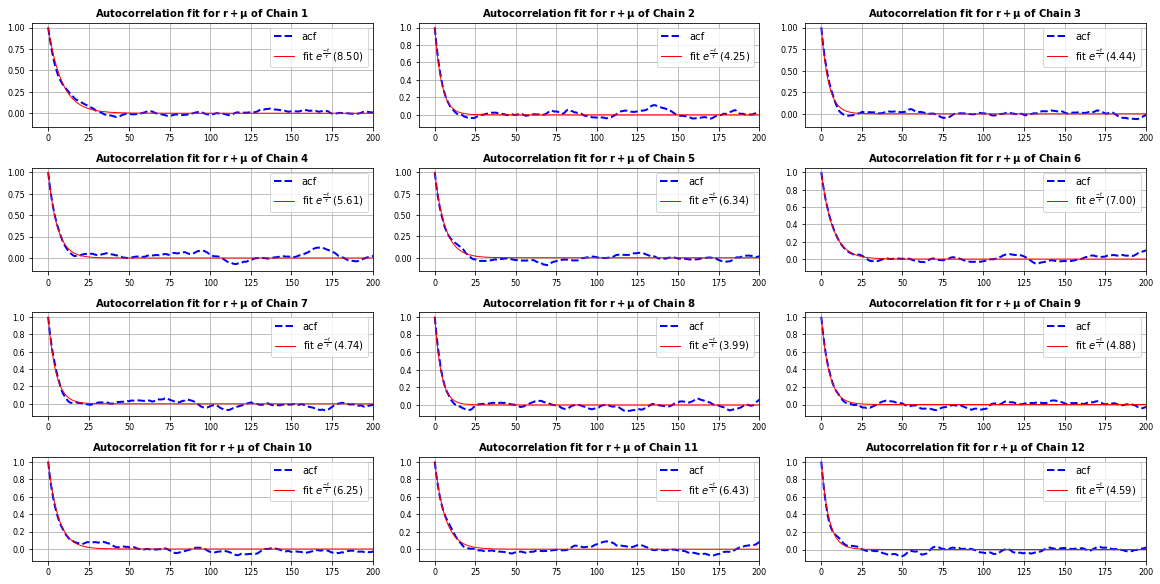

In [28]:
analysis_esp.autocorr_fit_plot(var='rmu')

Where

$$\hat{R} = \sqrt{\frac{\hat{V}}{W}}$$ is the **potential scale reduction factor**
<br>
<br>
- &emsp; **W** is the within-chain variance (mean of variance of each chain),
<br>
- &emsp; $\hat{V}$ is the variance between multiple chains.
<br>
<br>
This is the potential scale reduction factor, which converges to unity when each of the traces is a sample from the target posterior.
<br>
Values greater than one indicate that one or more chains have not yet converged.
<br> The simulation was runned until the $\hat{R}$ of each parameter was < 1.01.

In [8]:
# Compute the median and std of sigmaI and sigmaX

tauI = analysis_esp.samples['tauI'].ravel()
std_I = np.power(tauI, -1/2)
sd_std_I = np.std(std_I)
std_I = np.median(std_I)

tauX = analysis_esp.samples['tauX'].ravel()
std_X = np.power(tauX, -1/2)
sd_std_X = np.std(std_X)
std_X = np.median(std_X)

std_I, sd_std_I, std_X, sd_std_X

(0.1320896345515278,
 0.019378499105078214,
 1.1400507956026582,
 0.1767337081966915)

(509.105848952488, 10182.116979049759, 0.2745856849806451)

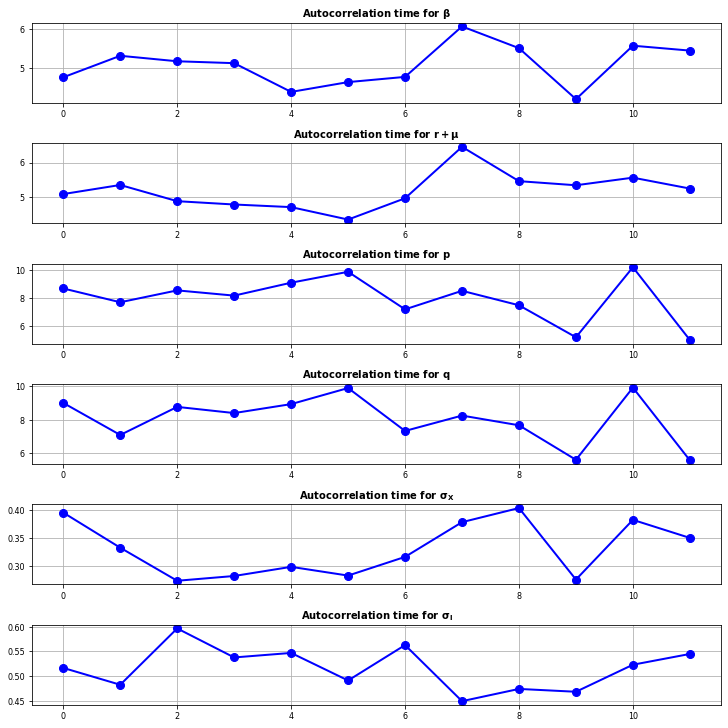

In [23]:
analysis_esp.autocorrelation_time_plot()
analysis_esp.times.max()*50, analysis_esp.times.max()*1000, analysis_esp.times.min()

### Posterior of the time to reach the peak of the epidemic

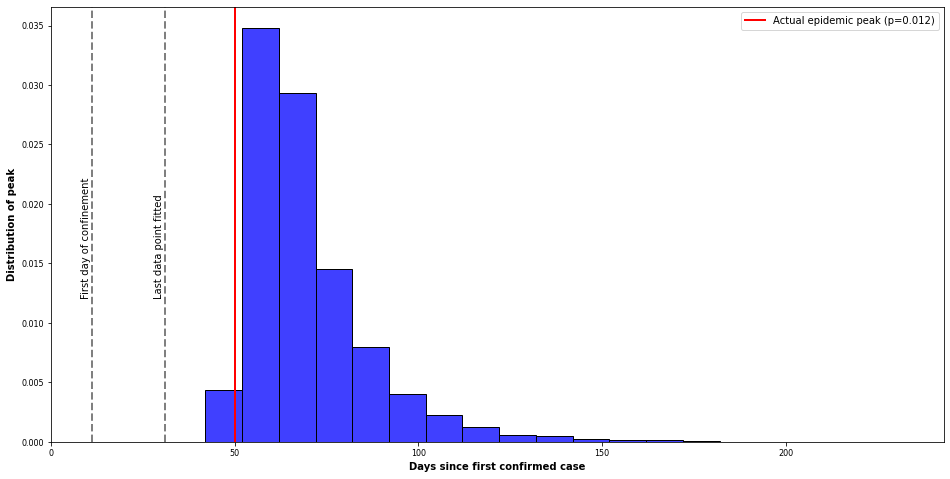

In [29]:
analysis_esp.peak_posterior()

analysis_esp.traces.to_csv('data.csv', index=False)

### Kolmogorov smirnov test for goodness of fit

Ks_2sampResult(statistic=0.40625, pvalue=0.009516275438959759)
0.9975196071526129


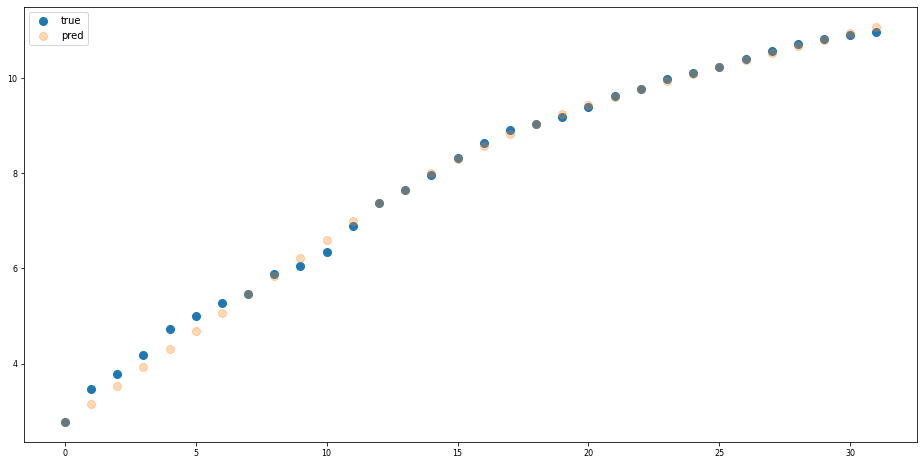

In [29]:
I = analysis_esp.data()['I']
t0 = analysis_esp.data()['t0'] - 1
tmax = analysis_esp.data()['tmax']
I_exact = analysis_esp.infected_exact()

y_true = I[t0:tmax]
y_pred = I_exact[t0:tmax]

from scipy import stats
from scipy.stats import ks_2samp

test = ks_2samp(y_true+2, y_pred)
print(test)
print((stats.linregress(y_true, y_pred)[2]) ** 2)


plt.scatter(np.arange(len(y_true)), y_true, label='true')
plt.scatter(np.arange(len(y_pred)), y_pred, label='pred', alpha=0.3)
plt.legend()


### Trace, posterior distribution, autocorrelation plot before peak (Spain)

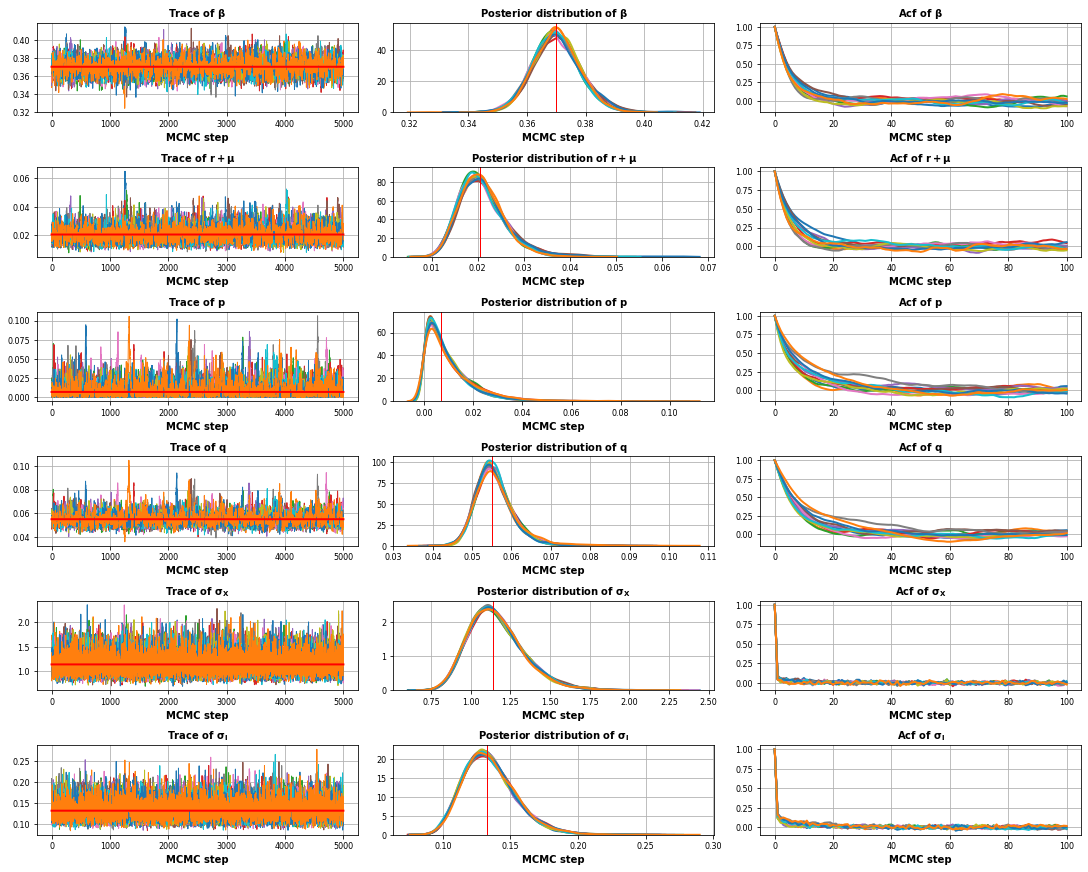

In [30]:
analysis_esp.plot_summary()

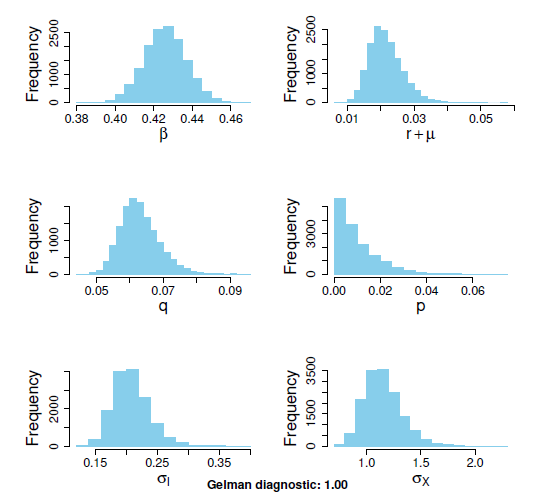

In [112]:
Image("../Immagini/Posterior Distribution paper.png")

In [83]:
#t_esp, *states_esp = analysis_esp.solve_SCIR()
#plt.plot(t_esp, np.log(states_esp[2])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')

### Plotting fit results before peak

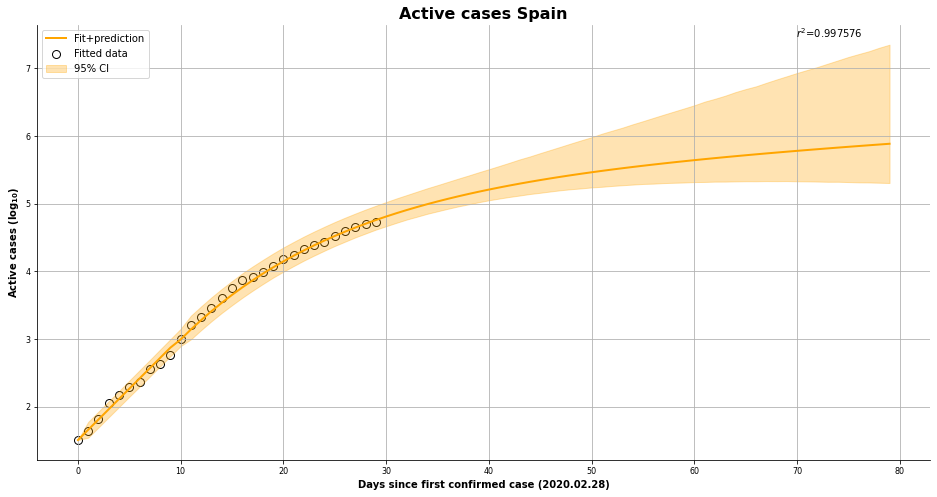

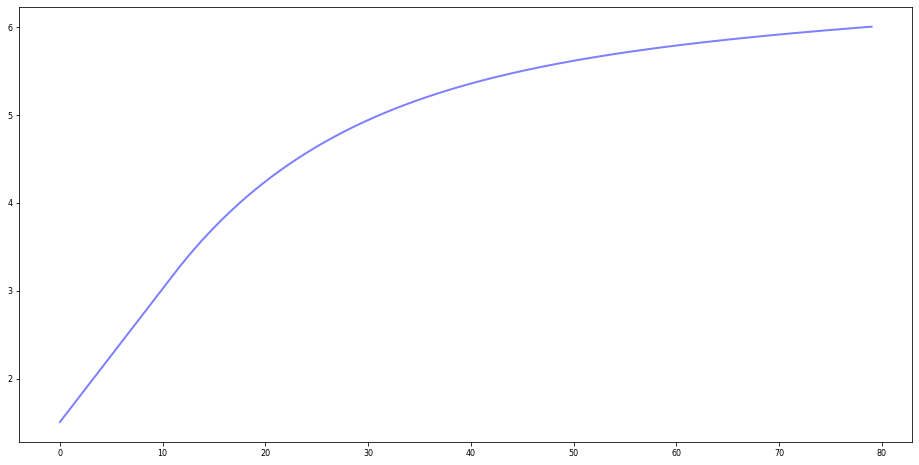

In [48]:
analysis_esp.plot_results(CI=95, Y=True, observed=False)
ax = plt.gca()
ax.plot(t_esp, np.log(SCIX_esp[2])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')

def doubling_time(self, tf=60, taud=2):
    N0 = np.exp(self.data['I0'])
    t = np.arange(tf)
    Nt = np.log(N0) + t / taud * np.log(2)

    plt.plot(t, Nt / np.log(10), '--', c='gray')
    return Nt
    
#doubling_time(analysis_esp, taud=2)
#plt.plot(t_esp, np.log(SCIX_esp[2])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')
#plt.savefig("active_cases_Spain.png", quality=100, transparent=True, dpi=400)

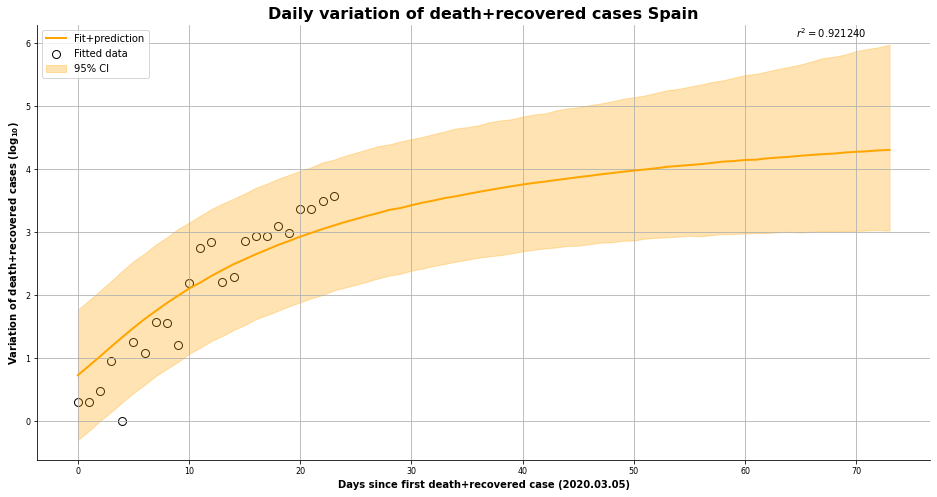

In [37]:
analysis_esp.plot_results(Z=True, observed=False)
#plt.plot(t_esp[:], np.log(SCIX_esp[3])/np.log(10), 'b', alpha=0.5, lw=2, label='simulated')
#plt.savefig("death_recovered_Spain.png", quality=100, transparent=True, dpi=400)

## Fit ending after peak data for the daily number of active cases

In [54]:
df

Day    Death  Confirmed  Recovered  Confirmed_smooth  \
0   2020.02.28      0.0       32.0        0.0              24.0   
1   2020.02.29      0.0       44.0        0.0              38.0   
2   2020.03.01      0.0       66.0        0.0              55.0   
3   2020.03.02      0.0      114.0        0.0              90.0   
4   2020.03.03      0.0      150.0        0.0             132.0   
..         ...      ...        ...        ...               ...   
75  2020.05.13  27091.0    60777.0   140823.0           61570.0   
76  2020.05.14  27308.0    58858.0   143374.0           59817.5   
77  2020.05.15  27449.0    57951.0   144783.0           58404.5   
78  2020.05.16  27549.0    56703.0   146446.0           57327.0   
79  2020.05.17  27634.0    54140.0   149576.0           55421.5   

    Recovered_Death  Recovered_Death_smooth  
0               0.0                    -1.5  
1               0.0                     0.0  
2               0.0                     0.0  
3               0.0                     0.0  
4               0.0                     0.0  
..              ...                     ...  
75           2025.0                  2019.0  
76           2768.0                  2396.5  
77           1550.0                  2159.0  
78           1763.0                  1656.5  
79           3215.0                  2489.0  

[80 rows x 7 columns]

In [8]:
analysis_esp_2 = Analysis(date=df['Day'].to_numpy(),
                          confirmed=df['Confirmed'].to_numpy(),
                          recovered_death=df['Recovered_Death'].to_numpy(),
                          quarantine='2020.03.09',
                          last_data='2020.04.18',
                          last_projection='2021.03.01',
                          peak='2020.04.18',
                          beta=[0,1],
                          rmu=[0,1],
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],
                          country='Spain')

In [9]:
%%time
# call sampler analysis' method
analysis_esp_2.sampler(nchains=12, nthreads=12, niter=30000, burn_in=0.5)

sampling: iterations 9373 of 360000, elapsed 0:00:05, remaining 0:03:21
sampling: iterations 84475 of 360000, elapsed 0:00:10, remaining 0:00:34
sampling: iterations 144452 of 360000, elapsed 0:00:16, remaining 0:00:23
sampling: iterations 204178 of 360000, elapsed 0:00:21, remaining 0:00:16
sampling: iterations 259081 of 360000, elapsed 0:00:26, remaining 0:00:10
sampling: iterations 320175 of 360000, elapsed 0:00:31, remaining 0:00:04
sampling: iterations 360000 of 360000, elapsed 0:00:33, remaining 0:00:00
CPU times: user 6min 22s, sys: 4.6 s, total: 6min 27s
Wall time: 42.6 s


In [10]:
analysis_esp_2.summary()

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta   0.3981   0.1251    0.3842     0.8898  1.2192
rmu    0.0328   0.1293    0.0239     0.5390  1.2208
q      0.0596   0.0109    0.0200     0.0642  1.2187
p      0.0004   0.0038    0.0000     0.0154  1.2121
tauI  51.2303  18.7008   31.9275   111.4207  1.1952
tauX   1.0563   0.3667    0.0919     1.6315  1.2122

In [7]:
y = analysis_esp_2.samples['y']
tmax = analysis_esp_2.data['tmax'] - 1

In [8]:
%%timeit

nchains = y.shape[2]
niters = y.shape[1]
length = nchains * niters
result = np.empty(length, dtype=np.float64)
i = 0
for k in range(nchains):
    for j in range(niters):
        result[i] = (y[tmax:, j, k] < np.log(1000)).argmax() + tmax
        i += 1

KeyboardInterrupt: 

In [11]:
from multiprocessing import Pool, cpu_count
import itertools


def end_epidemic(param):
    k, j = param
    return (y[tmax:, j, k] < np.log(1000)).argmax() + tmax

In [15]:
#%%timeit

nchains = y.shape[2]
niters = y.shape[1]
paramlist = list(itertools.product(range(nchains), range(niters)))

p = Pool(cpu_count() - 1)
res = np.asarray(p.map(end_epidemic, paramlist))
p.close()


res

array([275, 259, 258, ..., 218, 218, 213])

In [66]:
#np.save('y_prova', analysis_esp_2.samples['y'])

analysis_esp_2.samples['y'][:, :, :2].nbytes, analysis_esp_2.samples['y'].nbytes

(88320000, 529920000)

### Trace, posterior distribution, autocorrelation plot after peak (Spain)

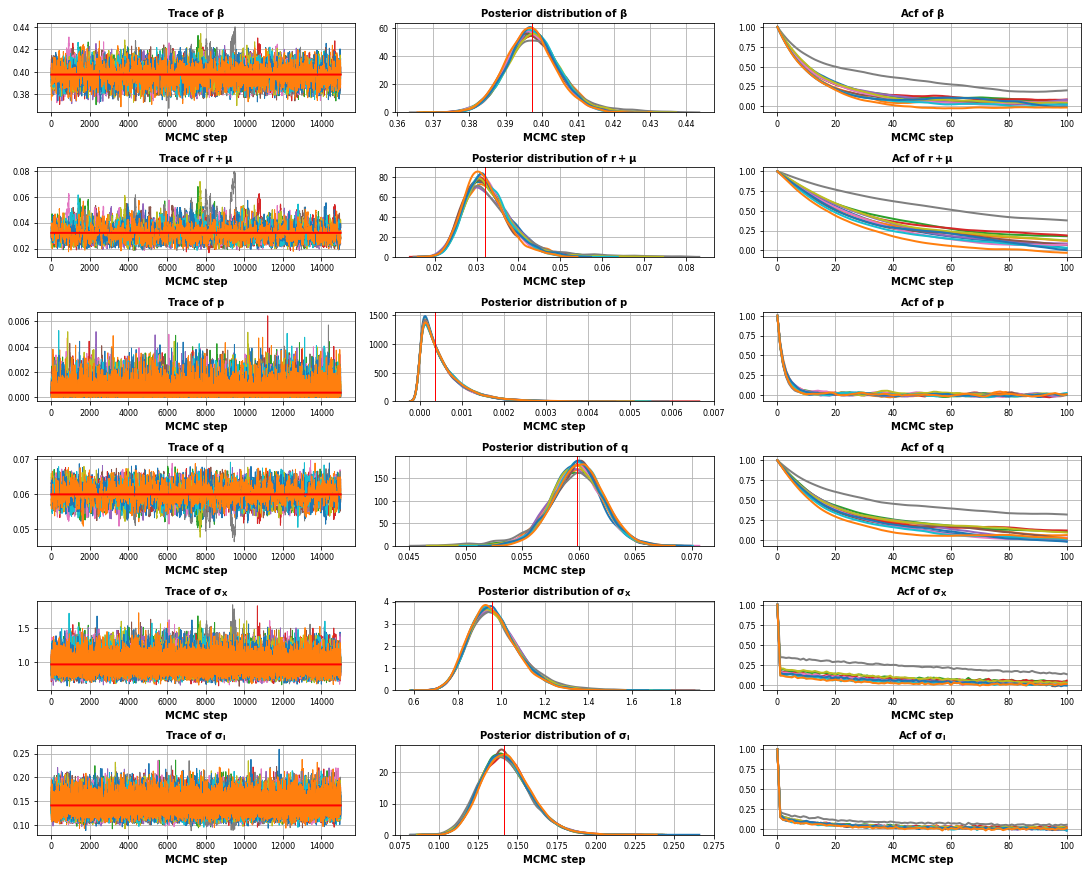

In [58]:
analysis_esp_2.plot_summary()

(2835.7507571243623, 56715.015142487246)

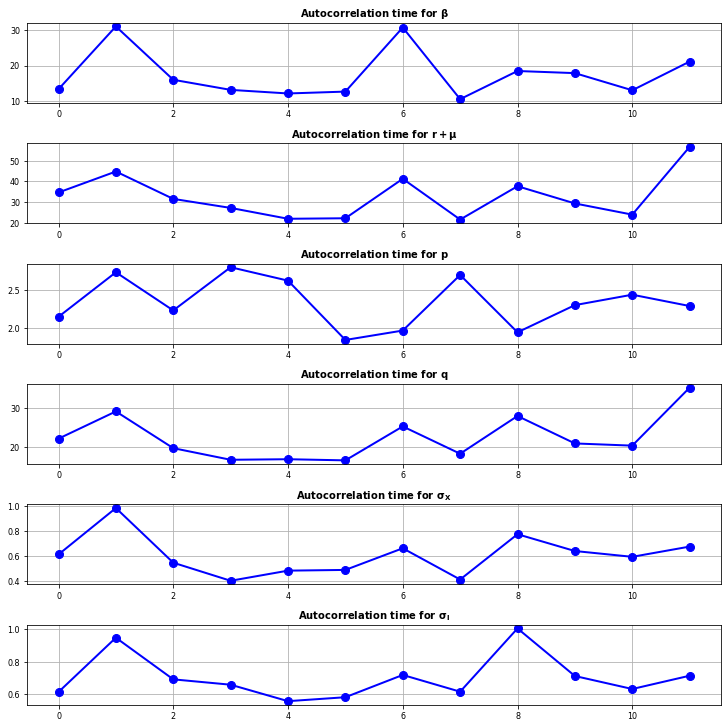

In [126]:
analysis_esp_2.autocorrelation_time_plot()
analysis_esp_2.times.max()*50, analysis_esp_2.times.max()*1000

### Distribution of times until the number of confirmed cases falls below 1000 for the first time (Spain)

232.0 53.672861643434324
CPU times: user 1.38 s, sys: 120 ms, total: 1.5 s
Wall time: 1.42 s


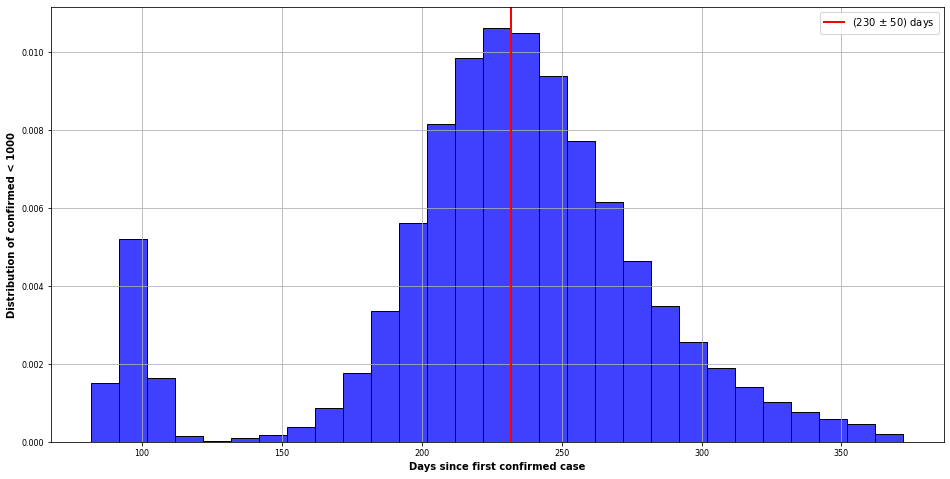

In [11]:
%%time

analysis_esp_2.end_epidemic_plot1()

### Plotting fit results after peak

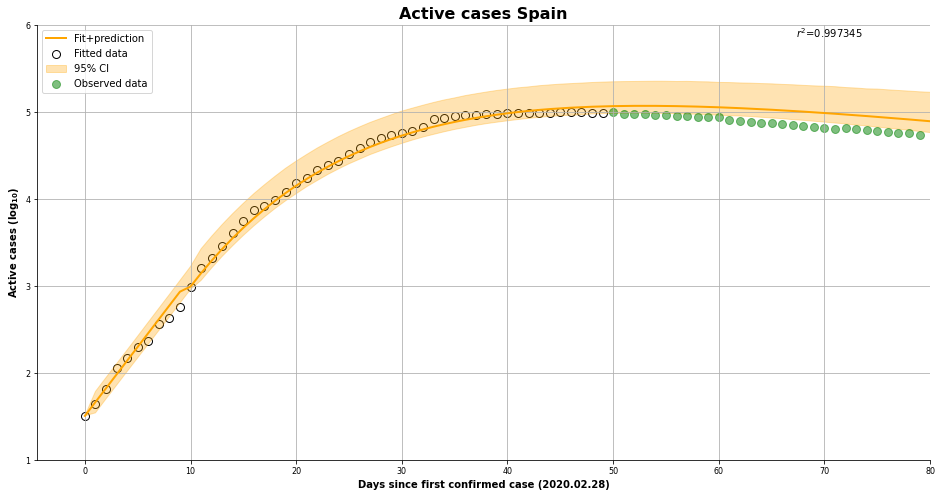

In [128]:
analysis_esp_2.plot_results(Y=True, observed=True)
plt.xlim(-4.5, 80)
plt.ylim(1, 6);

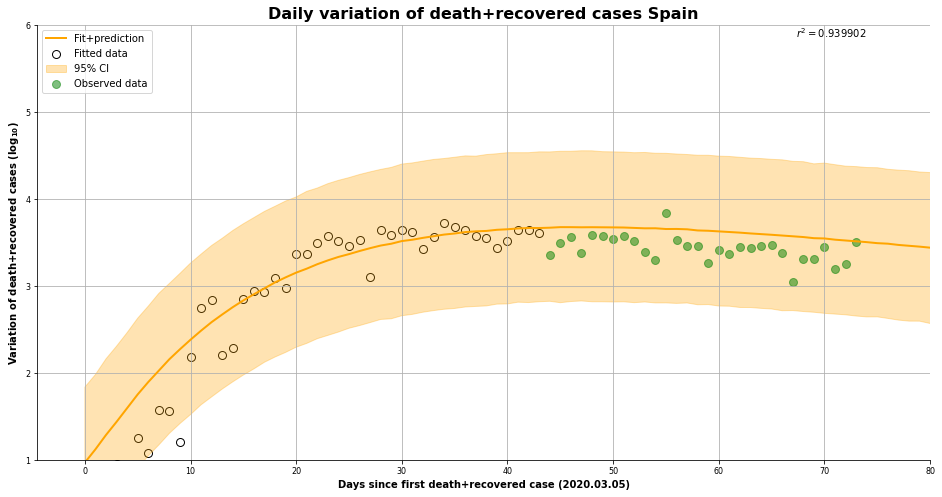

In [129]:
analysis_esp_2.plot_results(Z=True, observed=True)
plt.xlim(-4.5, 80)
plt.ylim(1, 6);

# Dataset Italy
The data is taken from Protezione Civile site, starting from 2020.02.24.

In [165]:
# dataset active cases
# all data from 2020-02-28 to today
url_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento" + \
            "-nazionale/dpc-covid19-ita-andamento-nazionale.csv"

df1 = pd.read_csv(url_ita)[['data', 'totale_casi', 'dimessi_guariti', 'deceduti']]
df1.columns = ['Day', 'Confirmed', 'Recovered', 'Death']
df1['Day'] = pd.to_datetime(df1.Day, format='%Y.%m.%d').dt.strftime('%Y.%m.%d')


df1['Confirmed'] = df1.Confirmed - df1.Recovered - df1.Death
df1['Confirmed_smooth'] = df1.Confirmed.rolling(7, min_periods=1).mean()
df1['Recovered_Death'] = (df1.Recovered + df1.Death).diff().fillna(0) # (daily derivative)
df1['Recovered_Death_smooth'] = df1.Recovered_Death.rolling(7, min_periods=1).mean()


df1

Day  Confirmed  Recovered  Death  Confirmed_smooth  \
0    2020.02.24        221          1      7        221.000000   
1    2020.02.25        311          1     10        266.000000   
2    2020.02.26        385          3     12        305.666667   
3    2020.02.27        588         45     17        376.250000   
4    2020.02.28        821         46     21        465.200000   
..          ...        ...        ...    ...               ...   
362  2021.02.20     384623    2315687  95486     390714.714286   
363  2021.02.21     388895    2324633  95718     388730.714286   
364  2021.02.22     387903    2334968  95992     387274.285714   
365  2021.02.23     387948    2347866  96348     386454.571429   
366  2021.02.24     389433    2362465  96666     386535.857143   

     Recovered_Death  Recovered_Death_smooth  
0                0.0                0.000000  
1                3.0                1.500000  
2                4.0                2.333333  
3               47.0               13.500000  
4                5.0               11.800000  
..               ...                     ...  
362          12739.0            14538.142857  
363           9178.0            14465.000000  
364          10609.0            14262.142857  
365          13254.0            14044.142857  
366          14917.0            13762.571429  

[367 rows x 7 columns]

In [143]:
# Try to remove baseline of active cases and recovered+death cases
#df1.loc[df1.Day > '2020.08.27', 'Confirmed_smooth'] -= df1.loc[df1.Day == '2020.08.27', 'Confirmed_smooth'].to_numpy()
#df1.loc[df1.Day > '2020.08.27', 'Recovered_Death_smooth'] -= df1.loc[df1.Day == '2020.08.27', 'Recovered_Death'].to_numpy()
df1

Day  Confirmed  Recovered  Death  Confirmed_smooth  \
0    2020.02.26        385          3     12        305.666667   
1    2020.02.27        588         45     17        376.250000   
2    2020.02.28        821         46     21        465.200000   
3    2020.02.29       1049         50     29        562.500000   
4    2020.03.01       1577         83     34        707.428571   
..          ...        ...        ...    ...               ...   
360  2021.02.20     384623    2315687  95486     390714.714286   
361  2021.02.21     388895    2324633  95718     388730.714286   
362  2021.02.22     387903    2334968  95992     387274.285714   
363  2021.02.23     387948    2347866  96348     386454.571429   
364  2021.02.24     389433    2362465  96666     386535.857143   

     Recovered_Death  Recovered_Death_smooth  
0                4.0                2.333333  
1               47.0               13.500000  
2                5.0               11.800000  
3               12.0               11.833333  
4               38.0               15.571429  
..               ...                     ...  
360          12739.0            14538.142857  
361           9178.0            14465.000000  
362          10609.0            14262.142857  
363          13254.0            14044.142857  
364          14917.0            13762.571429  

[365 rows x 7 columns]

In [144]:
df1.Day[185]

'2020.08.29'

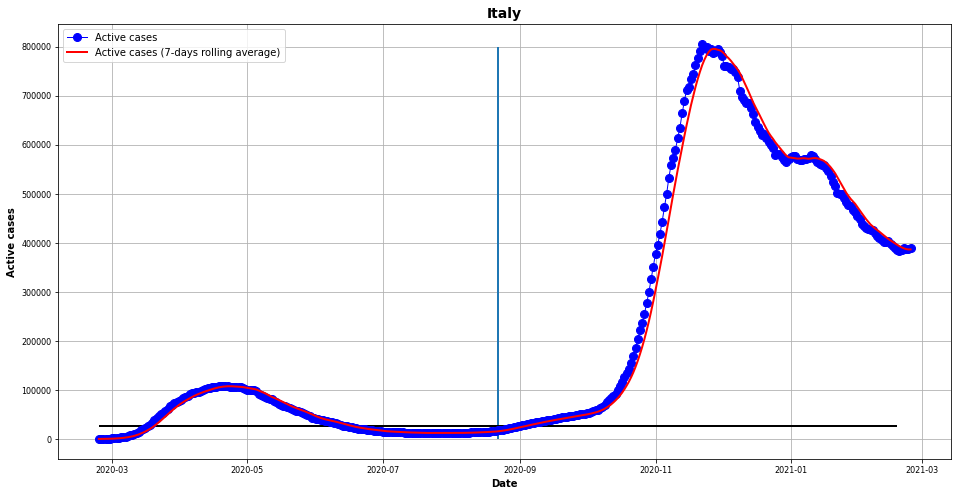

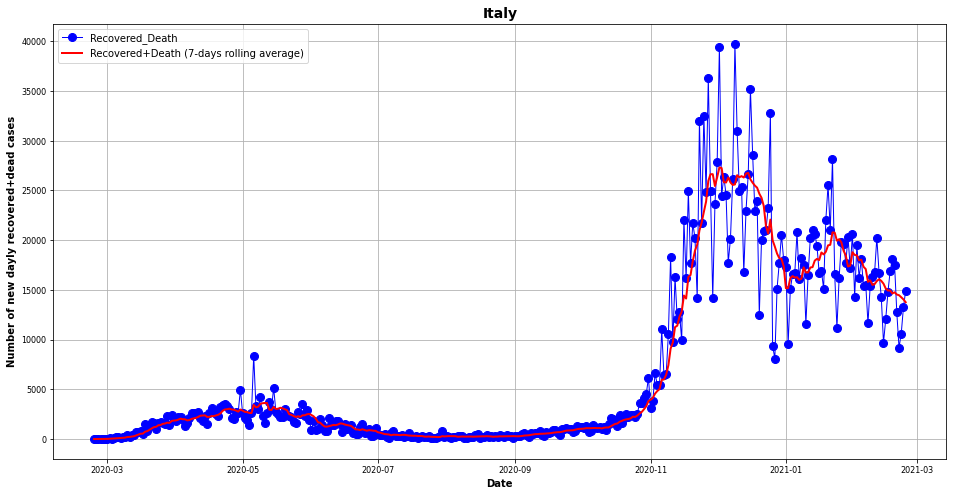

In [167]:
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed, 'bo-', lw=1, label='Active cases')
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed_smooth, 'r', lw=2, label='Active cases (7-days rolling average)')
plt.vlines(pd.to_datetime(df1.Day[180]), 0, 800000)
plt.hlines(df1.loc[224, 'Confirmed_smooth'] / 2, pd.to_datetime(df1.Day[0]), pd.to_datetime(df1.Day[360]), color='k')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("active_data_Italy.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death_smooth, 'r', lw=2, label='Recovered+Death (7-days rolling average)')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("recovered_death_data_Italy.png", quality=100, transparent=True, dpi=400)

In [168]:
# instantiating an analysis object
analysis_ita = Analysis(date=df1['Day'],
                        confirmed=df1['Confirmed_smooth'].to_numpy(),
                        recovered_death=df1['Recovered_Death_smooth'].to_numpy(),
                        quarantine='2020.03.09',
                        last_data='2020.04.01',
                        last_projection='2020.05.17',
                        peak='2020.04.23',
                        beta=[0,1],
                        rmu=[0,1],
                        q=[0,5],
                        p=[0,5],
                        tauI=[0.01, 0.01],
                        tauX=[0.01, 0.01],
                        country='Italy')

## Fit ending before peak data for the daily number of active cases
fit from 2020-02-24 to 2020-03-29 with confinement measure aplied on 2020-03-09

In [169]:
%%time
analysis_ita.sampler(nchains=12, nthreads=12, niter=50000, burn_in=0.5)

sampling: iterations 46181 of 600000, elapsed 0:00:06, remaining 0:01:12
sampling: iterations 319527 of 600000, elapsed 0:00:13, remaining 0:00:11
sampling: iterations 600000 of 600000, elapsed 0:00:17, remaining 0:00:00
CPU times: user 2min 19s, sys: 48.4 s, total: 3min 7s
Wall time: 56.3 s


In [170]:
analysis_ita.summary()

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.2416   0.0025    0.2368     0.2468  1.0004
rmu     0.0287   0.0019    0.0253     0.0327  1.0006
q       0.0468   0.0026    0.0434     0.0534  1.0011
p       0.0058   0.0061    0.0002     0.0227  1.0009
tauI  319.9504  79.4288  189.2673   499.3340  1.0001
tauX    6.5933   1.5848    3.9898    10.1656  1.0000

(736.3819094644299, 14727.638189288598)

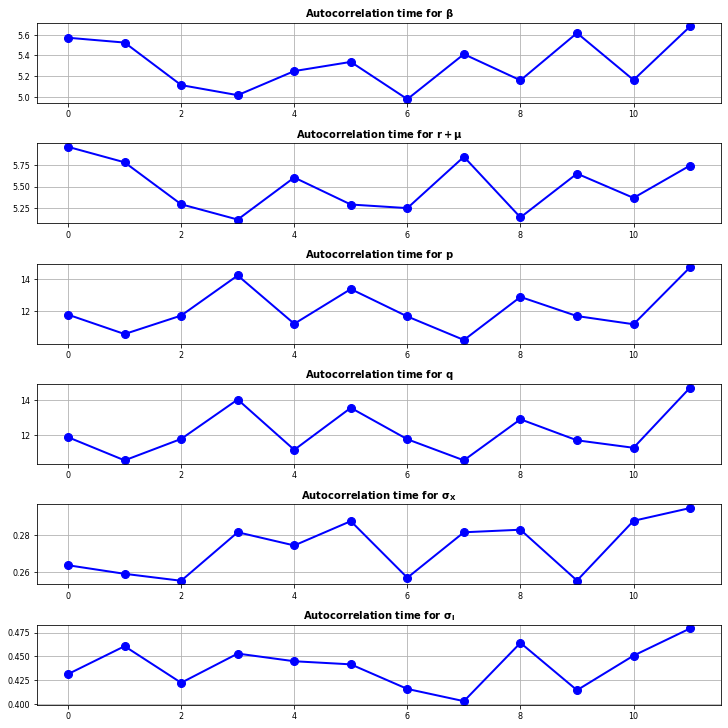

In [36]:
analysis_ita.autocorrelation_time_plot()
analysis_ita.times.max()*50, analysis_ita.times.max()*1000

### Trace, posterior distribution, autocorrelation plot before peak (Italy)

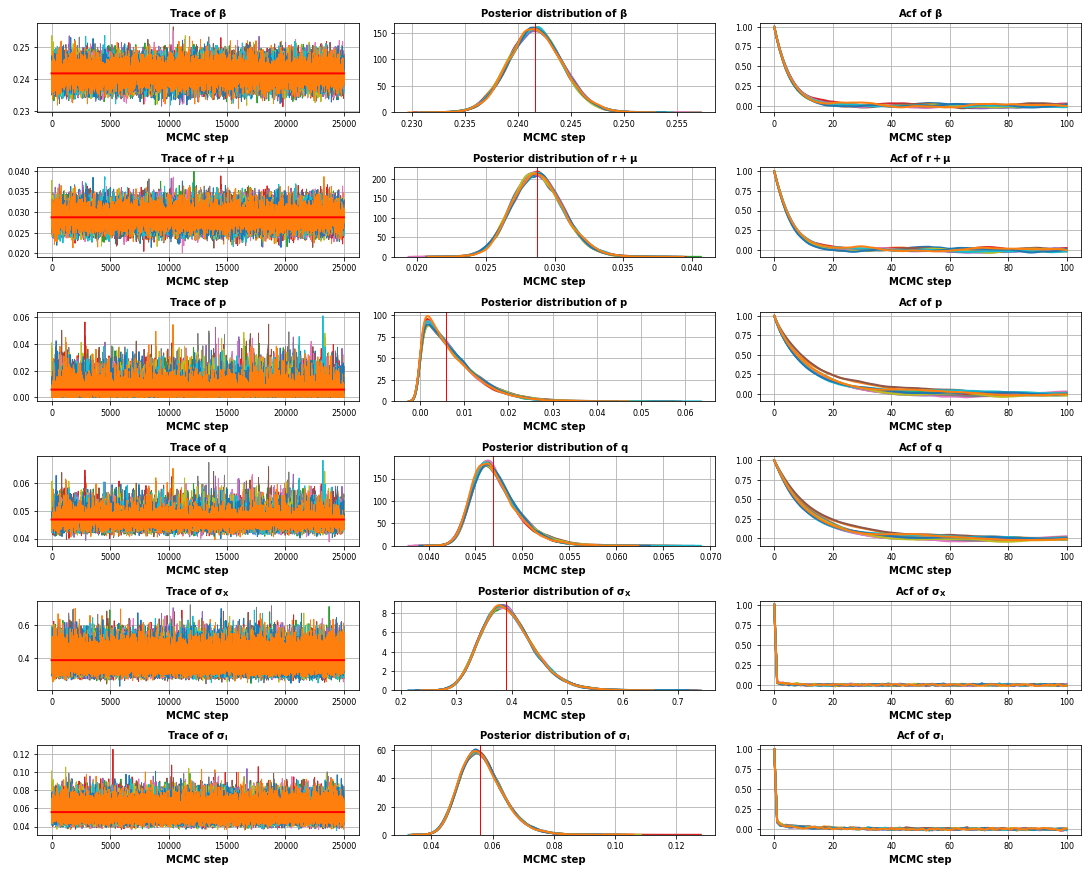

In [171]:
analysis_ita.plot_summary()

### Posterior of the time to reach the peak of the epidemic

Probability of actually have a peak: 53.73933333333333%


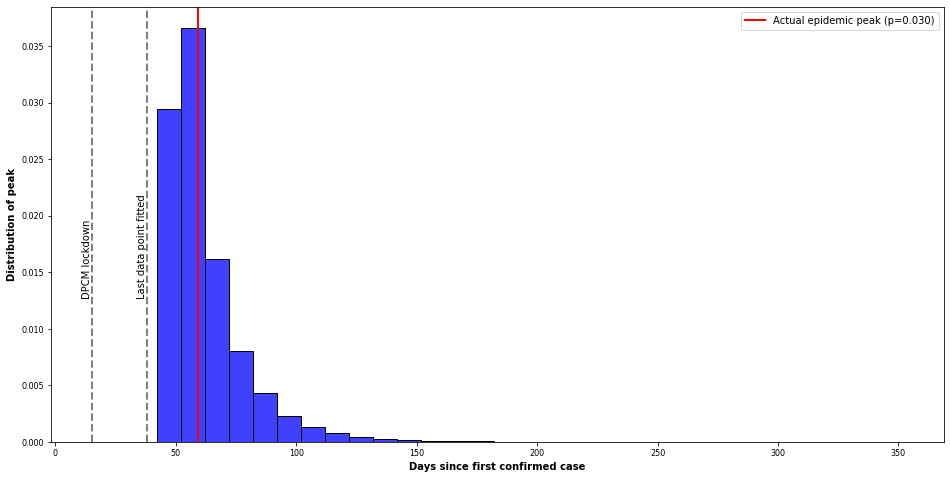

In [175]:
analysis_ita.peak_posterior(offset=4)
#plt.savefig("peak_posterior_Italy.png", quality=100, transparent=True, dpi=400)

### Plotting fit results before peak

fit from 2020-03-01 to 2020-03-31 with confinement measure applied on 2020-03-09

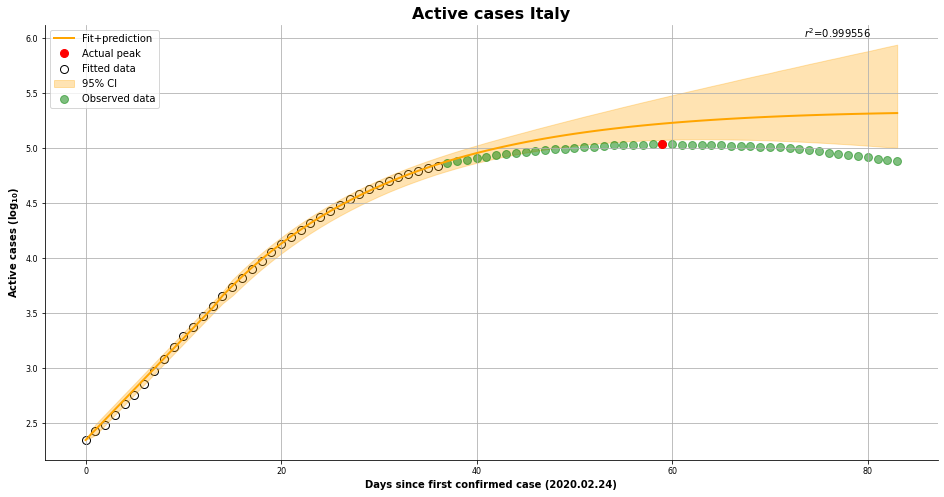

In [172]:
analysis_ita.plot_results(Y=True, observed=True)
#plt.savefig("active_cases_Italy.png", quality=100, transparent=True, dpi=400)

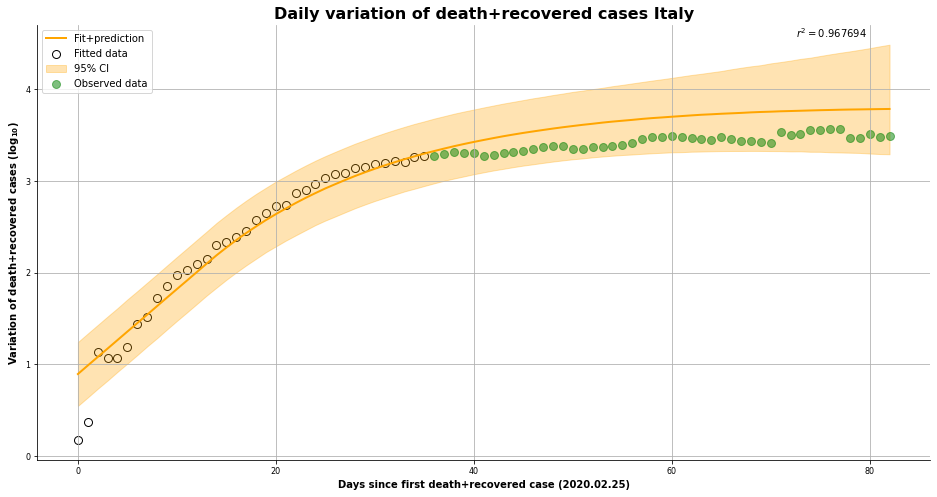

In [173]:
analysis_ita.plot_results(Z=True, observed=True)
#plt.savefig("death_recovered_Italy.png", quality=100, transparent=True, dpi=400)

## Fit ending after peak data for the daily number of active cases

In [7]:
analysis_ita_2 = Analysis(df1['Day'],
                          df1['Confirmed_smooth'].to_numpy(),
                          df1['Recovered_Death_smooth'].to_numpy(),
                          '2020.03.09',
                          '2020.04.23',
                          '2021.03.01',
                          'Italy',
                          '2020.04.23')

In [50]:
%%time
analysis_ita_2.sampler(nchains=12, nthreads=12, niter=60000, burn_in=0.5)

sampling: iterations 25736 of 720000, elapsed 0:00:05, remaining 0:02:26
sampling: iterations 89642 of 720000, elapsed 0:00:11, remaining 0:01:16
sampling: iterations 140128 of 720000, elapsed 0:00:16, remaining 0:01:07
sampling: iterations 190120 of 720000, elapsed 0:00:21, remaining 0:01:00
sampling: iterations 239366 of 720000, elapsed 0:00:26, remaining 0:00:53
sampling: iterations 292608 of 720000, elapsed 0:00:32, remaining 0:00:46
sampling: iterations 341400 of 720000, elapsed 0:00:37, remaining 0:00:41
sampling: iterations 381216 of 720000, elapsed 0:00:42, remaining 0:00:37
sampling: iterations 414828 of 720000, elapsed 0:00:48, remaining 0:00:35
sampling: iterations 462794 of 720000, elapsed 0:00:53, remaining 0:00:29
sampling: iterations 504849 of 720000, elapsed 0:00:58, remaining 0:00:25
sampling: iterations 546966 of 720000, elapsed 0:01:03, remaining 0:00:20
sampling: iterations 592097 of 720000, elapsed 0:01:08, remaining 0:00:15
sampling: iterations 651229 of 720000, e

In [51]:
analysis_ita_2.summary()

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.2434   0.0018    0.2400     0.2469  1.0007
rmu     0.0274   0.0012    0.0252     0.0298  1.0011
q       0.0493   0.0008    0.0478     0.0508  1.0006
p       0.0002   0.0003    0.0000     0.0012  1.0002
tauI  344.6864  66.8077  230.8377   491.6814  1.0001
tauX    9.4906   1.7945    6.3963    13.4157  1.0000

(679.8293727558171, 13596.587455116342)

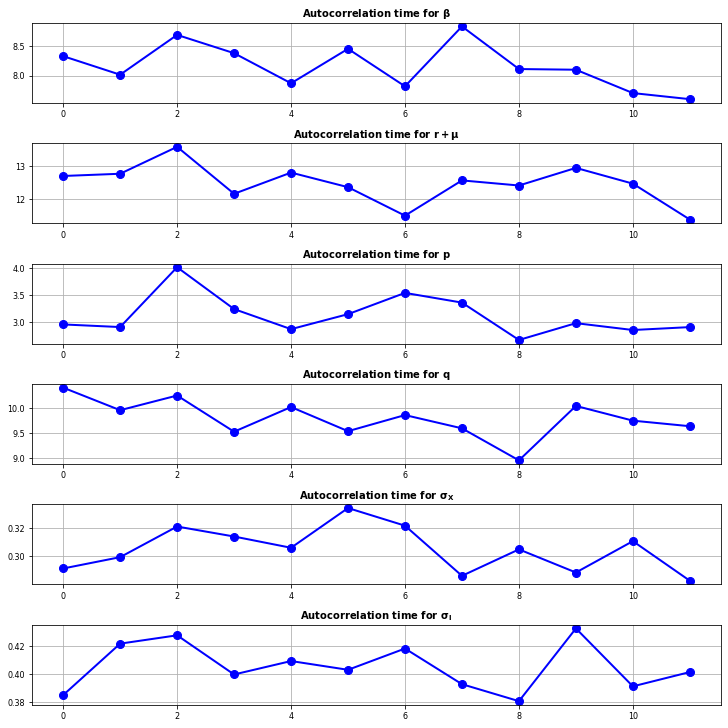

In [52]:
analysis_ita_2.autocorrelation_time_plot()
analysis_ita_2.times.max()*50, analysis_ita_2.times.max()*1000

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

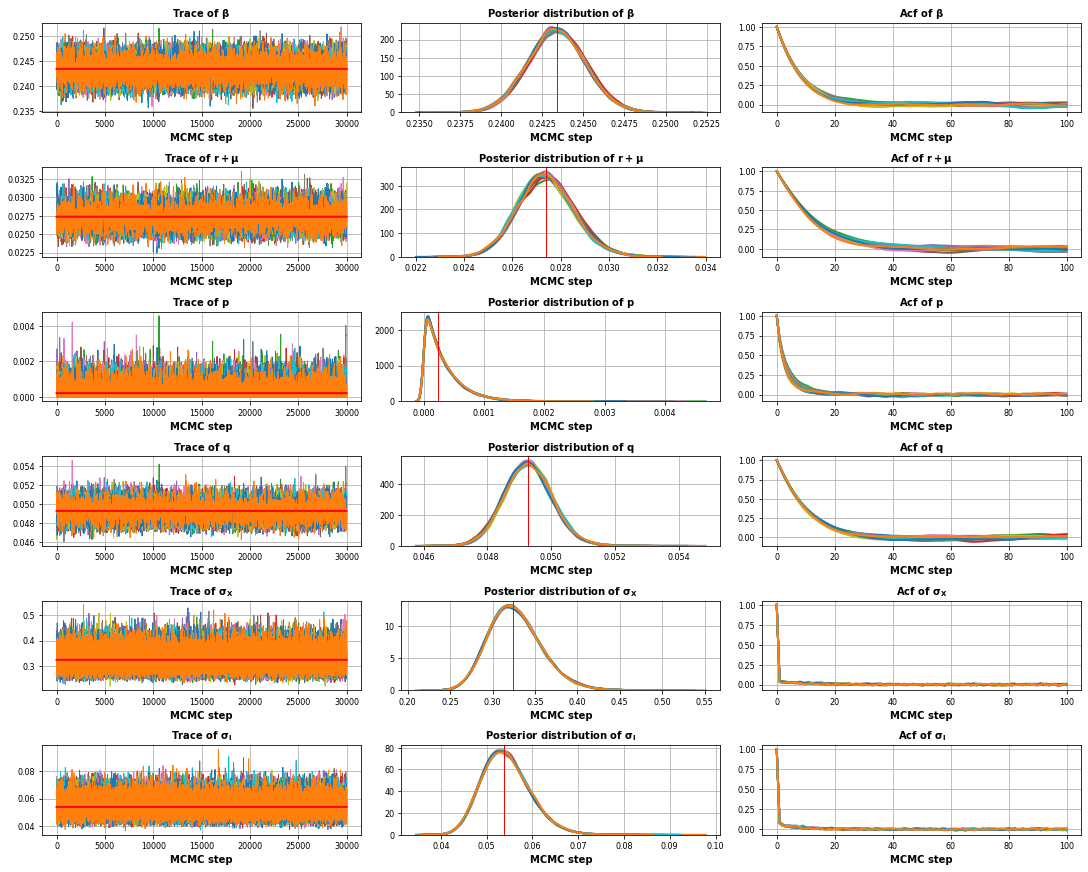

In [53]:
analysis_ita_2.plot_summary()

### Distribution of times until the number of confirmed cases falls below 1000 for the first time (Spain)

259.0 15.015662068091522
CPU times: user 2.33 s, sys: 46.9 ms, total: 2.38 s
Wall time: 2.39 s


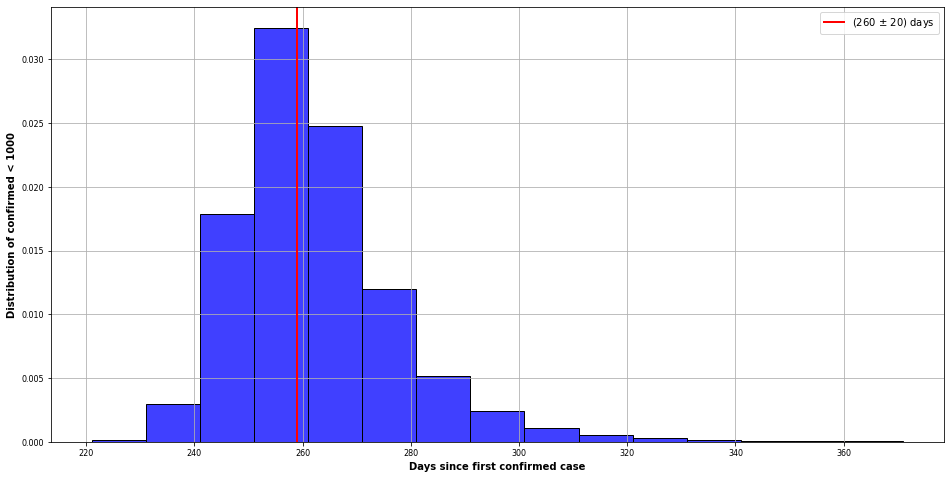

In [54]:
%%time

analysis_ita_2.end_epidemic_plot()

### Plotting fit results after peak

(2.0, 6.0)

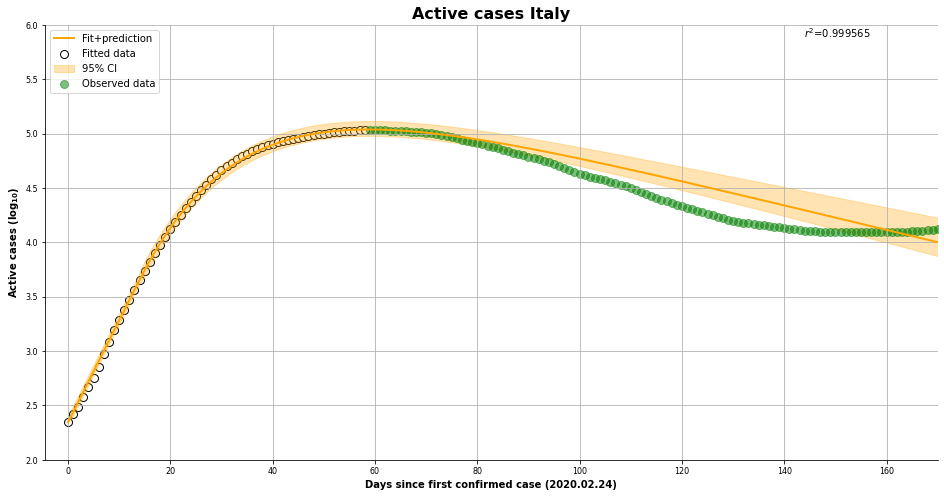

In [55]:
analysis_ita_2.plot_results(Y=True, observed=True)
plt.xlim(-4.5, 170)
plt.ylim(2, 6)

(0.0, 6.0)

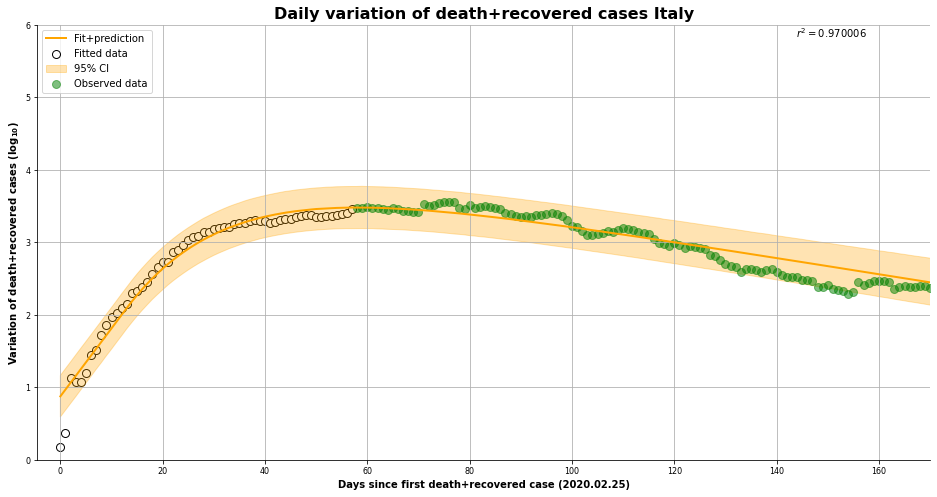

In [56]:
analysis_ita_2.plot_results(Z=True, observed=True)
plt.xlim(-4.5, 170)
plt.ylim(0, 6)

## Fit ending before peak data (second wave) 

In [57]:
print(df1.Confirmed_smooth.argmax())
df1.loc[df1.Day >= '2020.10.05']

277


Day  Confirmed  Recovered  Death  Confirmed_smooth  \
224  2020.10.05      58903     232681  36002      54347.857143   
225  2020.10.06      60134     234099  36030      55705.571429   
226  2020.10.07      62576     235303  36061      57321.714286   
227  2020.10.08      65952     236363  36083      59222.428571   
228  2020.10.09      70110     237549  36111      61524.285714   
..          ...        ...        ...    ...               ...   
361  2021.02.19     382448    2303199  95235     393113.285714   
362  2021.02.20     384623    2315687  95486     390714.714286   
363  2021.02.21     388895    2324633  95718     388730.714286   
364  2021.02.22     387903    2334968  95992     387274.285714   
365  2021.02.23     387948    2347866  96348     386454.571429   

     Recovered_Death  Recovered_Death_smooth  
224            783.0             1091.714286  
225           1446.0             1106.857143  
226           1235.0             1109.428571  
227           1082.0             1097.714286  
228           1214.0             1107.000000  
..               ...                     ...  
361          17523.0            14758.857143  
362          12739.0            14538.142857  
363           9178.0            14465.000000  
364          10609.0            14262.142857  
365          13254.0            14044.142857  

[142 rows x 7 columns]

In [176]:
df2 = df1.loc[df1.Day >= '2020.10.10'].reset_index(drop=True) # 2020.10.12, 2020.10.05
df2

Day  Confirmed  Recovered  Death  Confirmed_smooth  \
0    2020.10.10      74829     238525  36140      64276.142857   
1    2020.10.11      79075     239709  36166      67368.428571   
2    2020.10.12      82764     240600  36205      70777.142857   
3    2020.10.13      87193     242028  36246      74642.714286   
4    2020.10.14      92445     244065  36289      78909.714286   
..          ...        ...        ...    ...               ...   
133  2021.02.20     384623    2315687  95486     390714.714286   
134  2021.02.21     388895    2324633  95718     388730.714286   
135  2021.02.22     387903    2334968  95992     387274.285714   
136  2021.02.23     387948    2347866  96348     386454.571429   
137  2021.02.24     389433    2362465  96666     386535.857143   

     Recovered_Death  Recovered_Death_smooth  
0             1005.0             1068.571429  
1             1210.0             1139.285714  
2              930.0             1160.285714  
3             1469.0             1163.571429  
4             2080.0             1284.285714  
..               ...                     ...  
133          12739.0            14538.142857  
134           9178.0            14465.000000  
135          10609.0            14262.142857  
136          13254.0            14044.142857  
137          14917.0            13762.571429  

[138 rows x 7 columns]

In [177]:
analysis_ita_3 = Analysis(date=df2['Day'],
                          confirmed=df2['Confirmed_smooth'].to_numpy(),
                          recovered_death=df2['Recovered_Death_smooth'].to_numpy(), 
                          quarantine='2020.11.06',
                          last_data='2020.11.12',
                          last_projection='2020.12.31',
                          peak='2020.11.27',                         
                          beta=[0,1],  # try with [0, 0.2] cause here beta like 1/10
                          rmu=[0,1],   # try with [0, 0.2]
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],                          
                          country='Italy')

In [178]:
%%time
analysis_ita_3.sampler(nchains=12, nthreads=12, niter=100000, burn_in=0.5)

sampling: iterations 150613 of 1200000, elapsed 0:00:05, remaining 0:00:35
sampling: iterations 468656 of 1200000, elapsed 0:00:11, remaining 0:00:17
sampling: iterations 775204 of 1200000, elapsed 0:00:17, remaining 0:00:09
sampling: iterations 1200000 of 1200000, elapsed 0:00:21, remaining 0:00:00
CPU times: user 3min 9s, sys: 48.6 s, total: 3min 57s
Wall time: 1min


In [179]:
summary = analysis_ita_3.summary()
summary

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.0832   0.0008    0.0816     0.0848  1.0000
rmu     0.0147   0.0004    0.0141     0.0154  1.0000
q       0.8713   0.5884    0.1348     2.3617  1.0000
p       3.4467   1.2434    0.5653     4.9328  1.0001
tauI  279.3085  72.4157  161.4620   443.6880  1.0000
tauX   53.9275  13.5436   31.7387    84.6584  1.0000

(65260.815074766244, 1305216.3014953248)

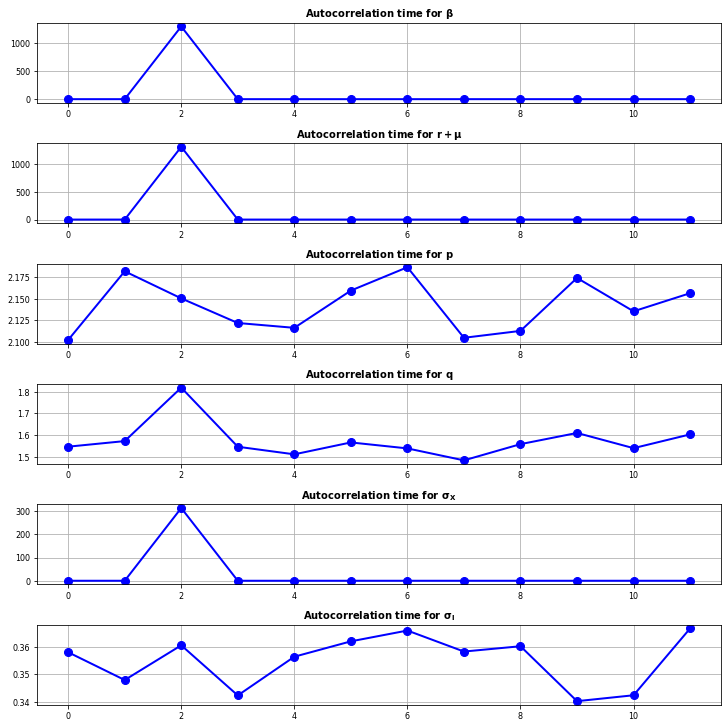

In [53]:
analysis_ita_3.autocorrelation_time_plot()
analysis_ita_3.times.max()*50, analysis_ita_3.times.max()*1000

### Trace, posterior distribution, autocorrelation plot before peak (Italy)

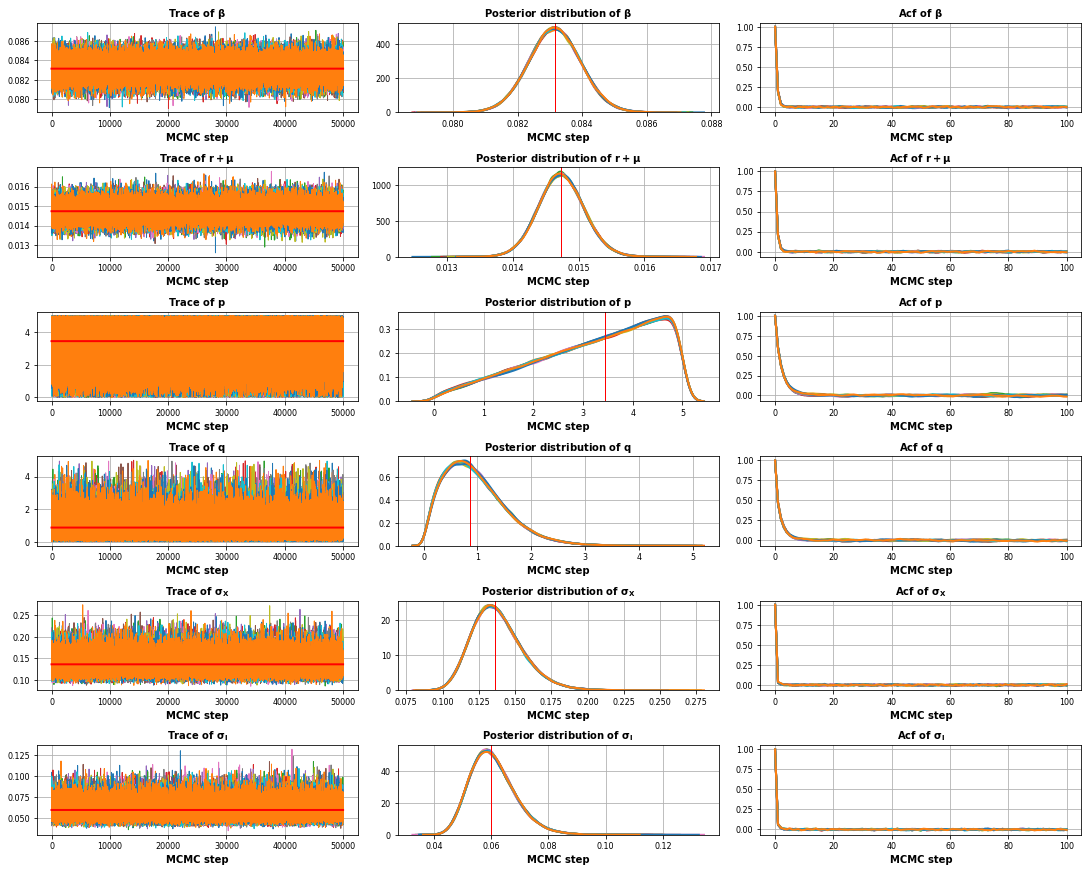

In [180]:
analysis_ita_3.plot_summary()

### Posterior of the time to reach the peak of the epidemic

In [181]:
beta = summary.loc['beta', 'median']
rmu = summary.loc['rmu', 'median']
p = summary.loc['p', 'median']
q = summary.loc['q', 'median']


1 / (p + q) * np.log(beta * q / (rmu * (p + q) - beta * p)), rmu * (p + q) / (beta * p)

(nan, 0.2213467564292266)

Probability of actually have a peak: 0.06316666666666666%


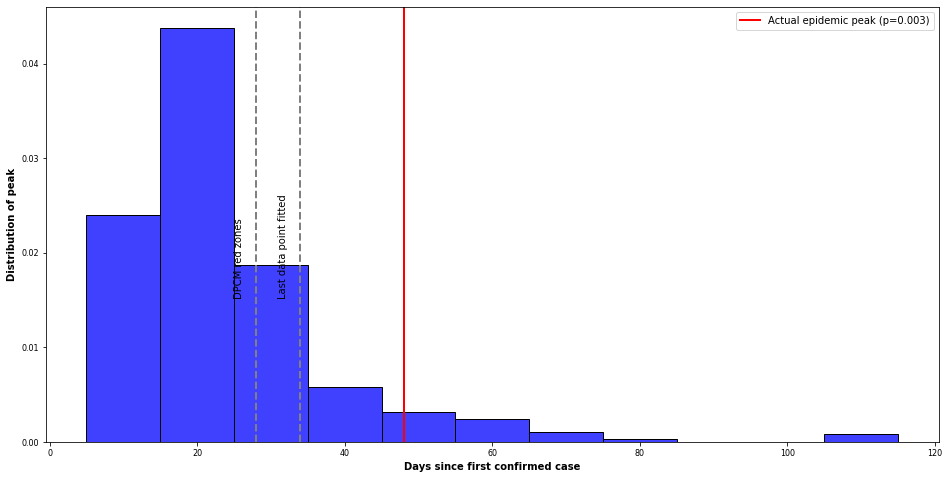

In [182]:
analysis_ita_3.peak_posterior(second_wave=True)

### Plotting fit results after peak

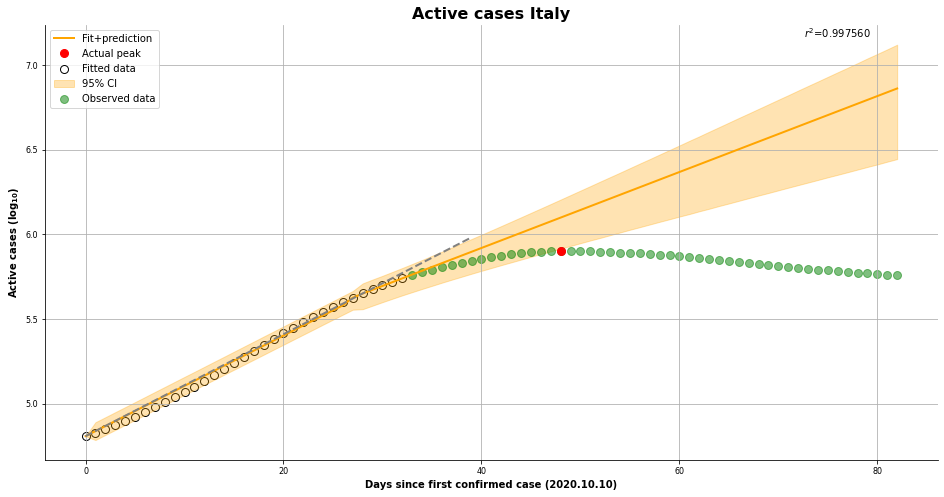

In [183]:
analysis_ita_3.plot_results(Y=True, observed=True)
doubling_time(analysis_ita_3, tf=40, taud=10);

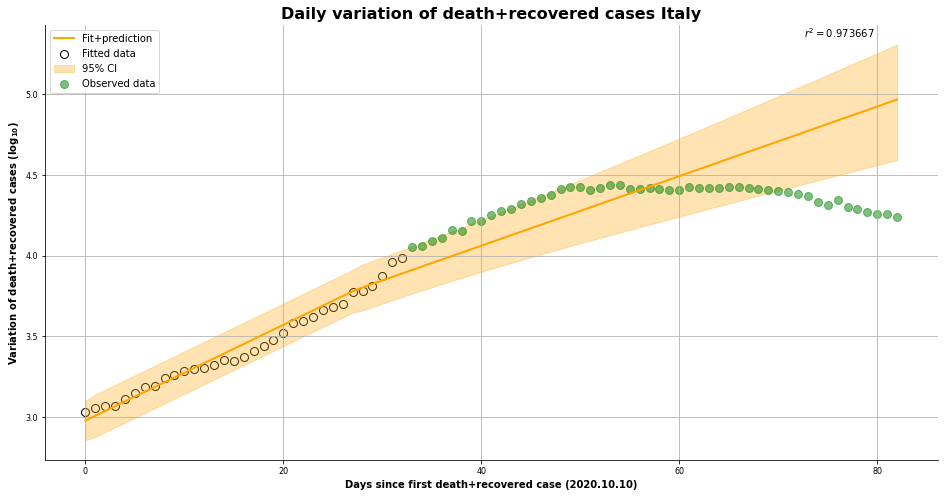

In [184]:
analysis_ita_3.plot_results(Z=True, observed=True)

# Fit ending after peak data (second wave)

In [185]:
analysis_ita_4 = Analysis(date=df2['Day'],
                          confirmed=df2['Confirmed_smooth'].to_numpy(),
                          recovered_death=df2['Recovered_Death_smooth'].to_numpy(), 
                          quarantine='2020.11.06',
                          last_data='2020.11.27',
                          last_projection='2022.03.01',
                          peak='2020.11.27',
                          beta=[0,1],  # try with [0, 0.2] cause here beta like 1/10
                          rmu=[0,1],   # try with [0, 0.2]
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],                            
                          country='Italy')

In [186]:
%%time
analysis_ita_4.sampler(nchains=12, nthreads=12, niter=20000, burn_in=0.5)

sampling: iterations 8289 of 240000, elapsed 0:00:06, remaining 0:02:35
sampling: iterations 80463 of 240000, elapsed 0:00:11, remaining 0:00:21
sampling: iterations 98460 of 240000, elapsed 0:00:11, remaining 0:00:16


KeyboardInterrupt: 

In [310]:
analysis_ita_4.summary()

median       sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.3175   0.1761    0.0842     0.5784  2.5650
rmu     0.2491   0.1762    0.0162     0.5100  2.5630
q       0.0244   0.1758    0.0103     0.1365  1.9608
p       0.0780   0.2892    0.0074     0.2779  1.1412
tauI  397.7392  88.1639  244.8622   590.9263  1.0085
tauX    0.1484   6.6122    0.0696    17.6156  1.8607

(86500.69313036154, 1730013.8626072307)

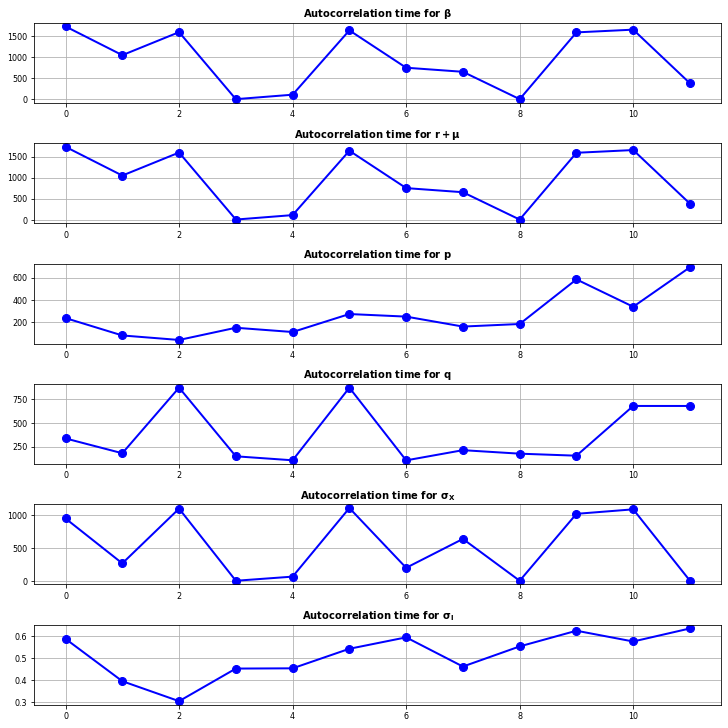

In [297]:
analysis_ita_4.autocorrelation_time_plot()
analysis_ita_4.times.max()*50, analysis_ita_4.times.max()*1000

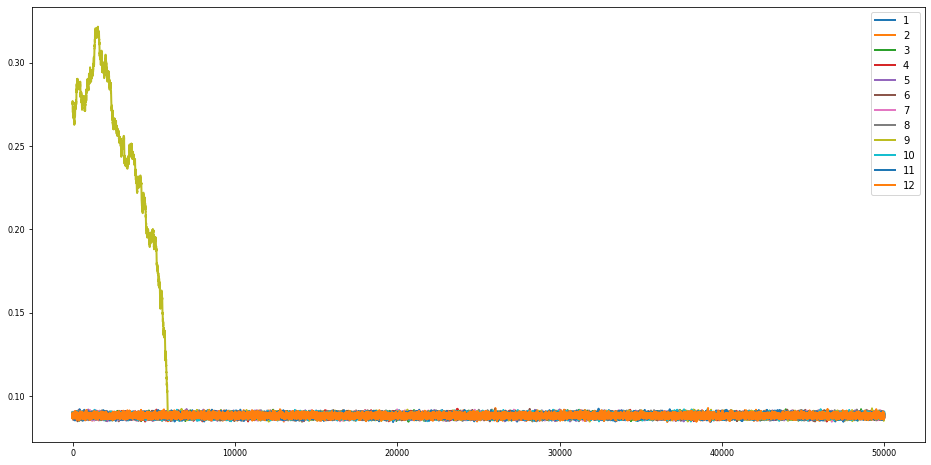

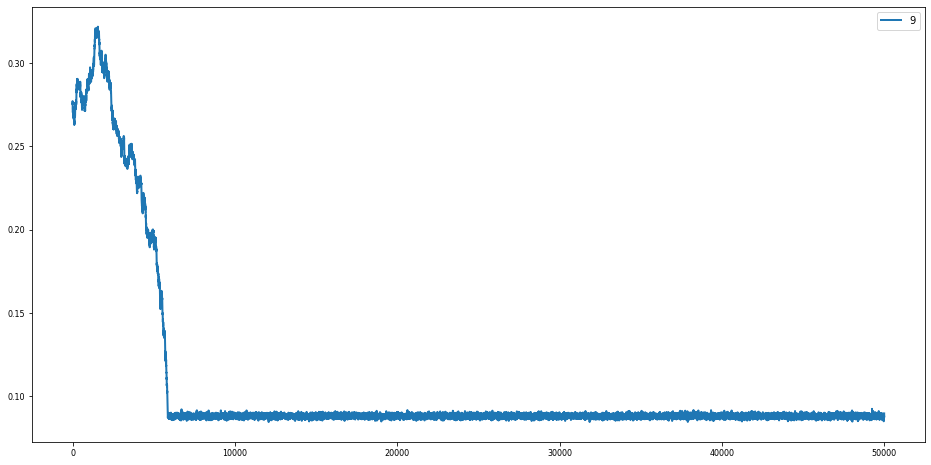

In [72]:
for i in range(analysis_ita_4.nchains):
    plt.plot(analysis_ita_4.samples['beta'][0, :, i], label=f'{i+1}')
    plt.legend()
plt.show()

i = 9
plt.plot(analysis_ita_4.samples['beta'][0, :, i-1], label=f'{i}')
plt.legend()
plt.show()

In [ ]:
# Override samples after discarding samples not converged
analysis_ita_4.samples = samples_mod

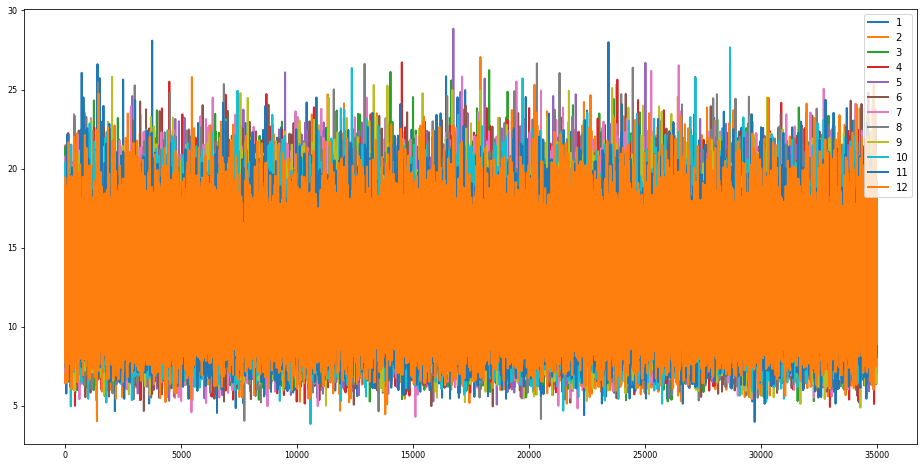

In [88]:
for i in range(analysis_ita_4.nchains):
    plt.plot(samples_mod['tauX'][0, :, i], label=f'{i+1}')
    plt.legend()
plt.show()

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

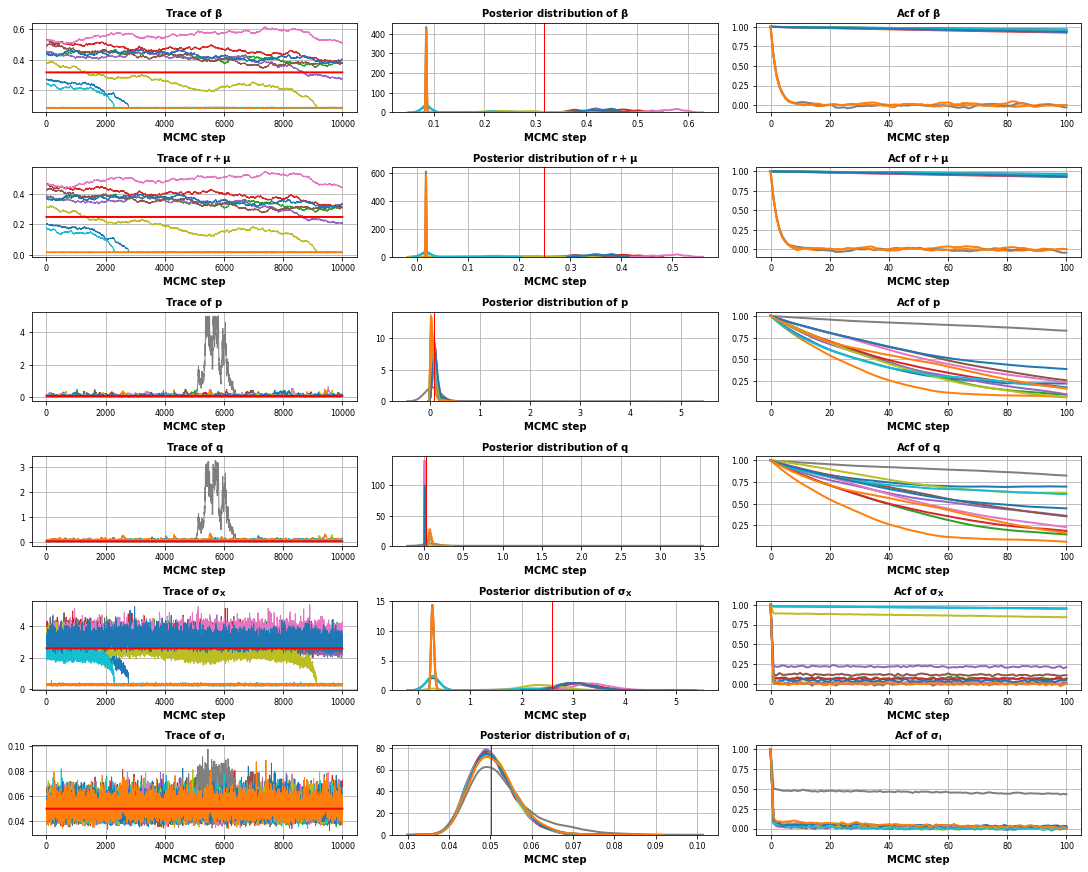

In [311]:
analysis_ita_4.plot_summary()

### Distribution of times until the number of confirmed cases falls below 1000 for the first time

293.0 111.23842727357771
CPU times: user 781 ms, sys: 62.5 ms, total: 844 ms
Wall time: 803 ms


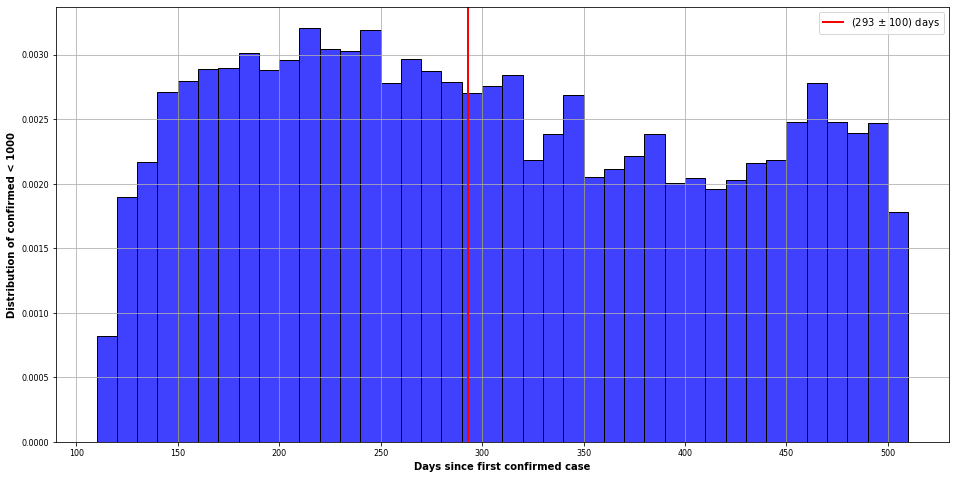

In [312]:
%%time

analysis_ita_4.end_epidemic_plot()

### Plotting fit results after peak

(4.5, 6.0)

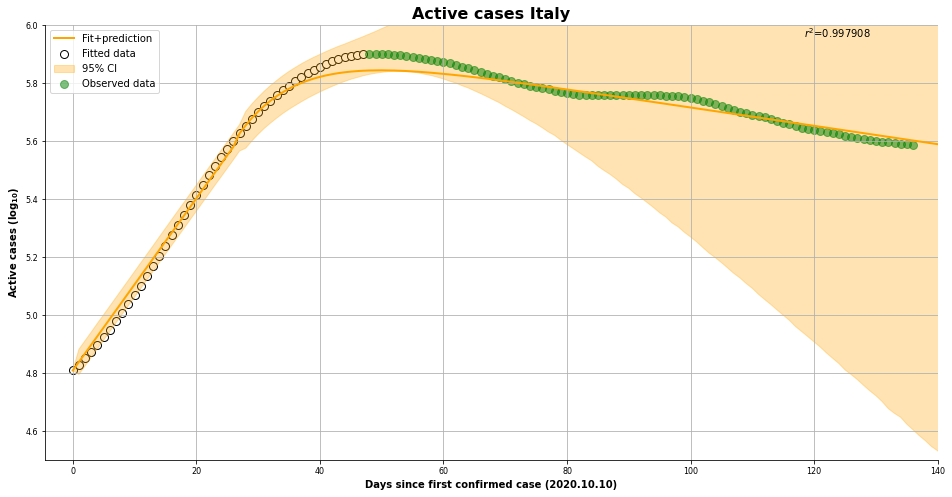

In [315]:
analysis_ita_4.plot_results(Y=True, observed=True)
plt.xlim(-4.5, 140)
plt.ylim(4.5, 7)

(2.0, 6.0)

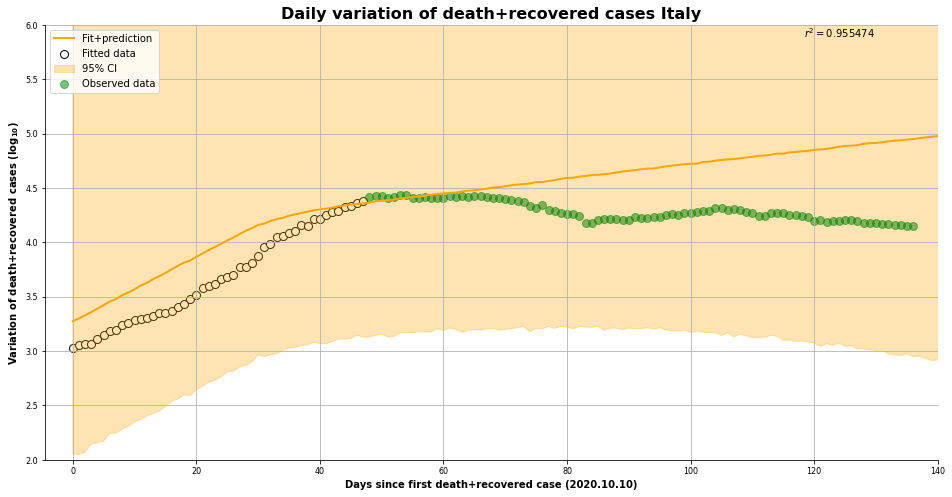

In [314]:
analysis_ita_4.plot_results(Z=True, observed=True)
plt.xlim(-4.5, 140)
plt.ylim(2, 6)

# Fit ending 3 weeks after peak data (second wave)

In [290]:
analysis_ita_5 = Analysis(date=df2['Day'],
                          confirmed=df2['Confirmed_smooth'].to_numpy(),
                          recovered_death=df2['Recovered_Death_smooth'].to_numpy(), 
                          quarantine='2020.11.06',
                          last_data='2020.12.18',
                          last_projection='2022.03.01',
                          peak='2020.11.27',
                          beta=[0,1],  # try with [0, 0.2] cause here beta like 1/10
                          rmu=[0,1],   # try with [0, 0.2]
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],                          
                          country='Italy')

In [302]:
%%time
analysis_ita_5.sampler(nchains=12, nthreads=12, niter=30000, burn_in=0.5)

sampling: iterations 4012 of 360000, elapsed 0:00:06, remaining 0:08:20
sampling: iterations 58371 of 360000, elapsed 0:00:11, remaining 0:00:55
sampling: iterations 103867 of 360000, elapsed 0:00:16, remaining 0:00:40
sampling: iterations 147899 of 360000, elapsed 0:00:21, remaining 0:00:31
sampling: iterations 184422 of 360000, elapsed 0:00:26, remaining 0:00:25
sampling: iterations 231146 of 360000, elapsed 0:00:32, remaining 0:00:18
sampling: iterations 280969 of 360000, elapsed 0:00:37, remaining 0:00:10
sampling: iterations 324493 of 360000, elapsed 0:00:42, remaining 0:00:05
sampling: iterations 360000 of 360000, elapsed 0:00:45, remaining 0:00:00
CPU times: user 8min 15s, sys: 36.7 s, total: 8min 51s
Wall time: 1min 16s


In [303]:
analysis_ita_5.summary()

median        sd  2.5%_hdi  97.5%_hdi   r_hat
beta    0.3841    0.2049    0.1026     0.8091  4.3250
rmu     0.3021    0.2049    0.0208     0.7271  4.3316
q       0.0214    0.0240    0.0100     0.0816  4.0213
p       0.0635    0.0242    0.0034     0.0773  2.3310
tauI  847.7833  148.9544  589.4151  1171.1485  1.0000
tauX    0.1367    2.3657    0.0697     7.2967  2.3462

(38419.14249457055, 768382.849891411)

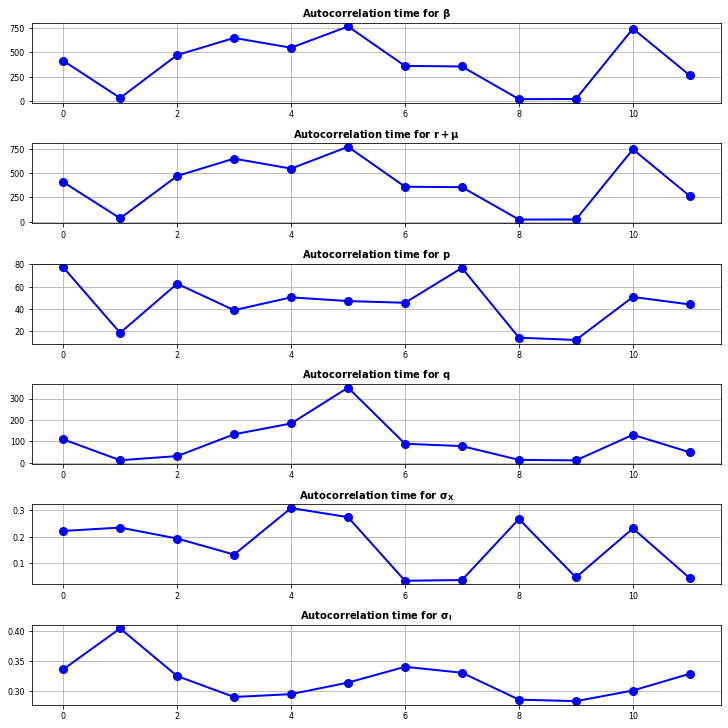

In [298]:
analysis_ita_5.autocorrelation_time_plot()
analysis_ita_5.times.max()*50, analysis_ita_5.times.max()*1000

### Trace, posterior distribution, autocorrelation plot after peak (Italy)

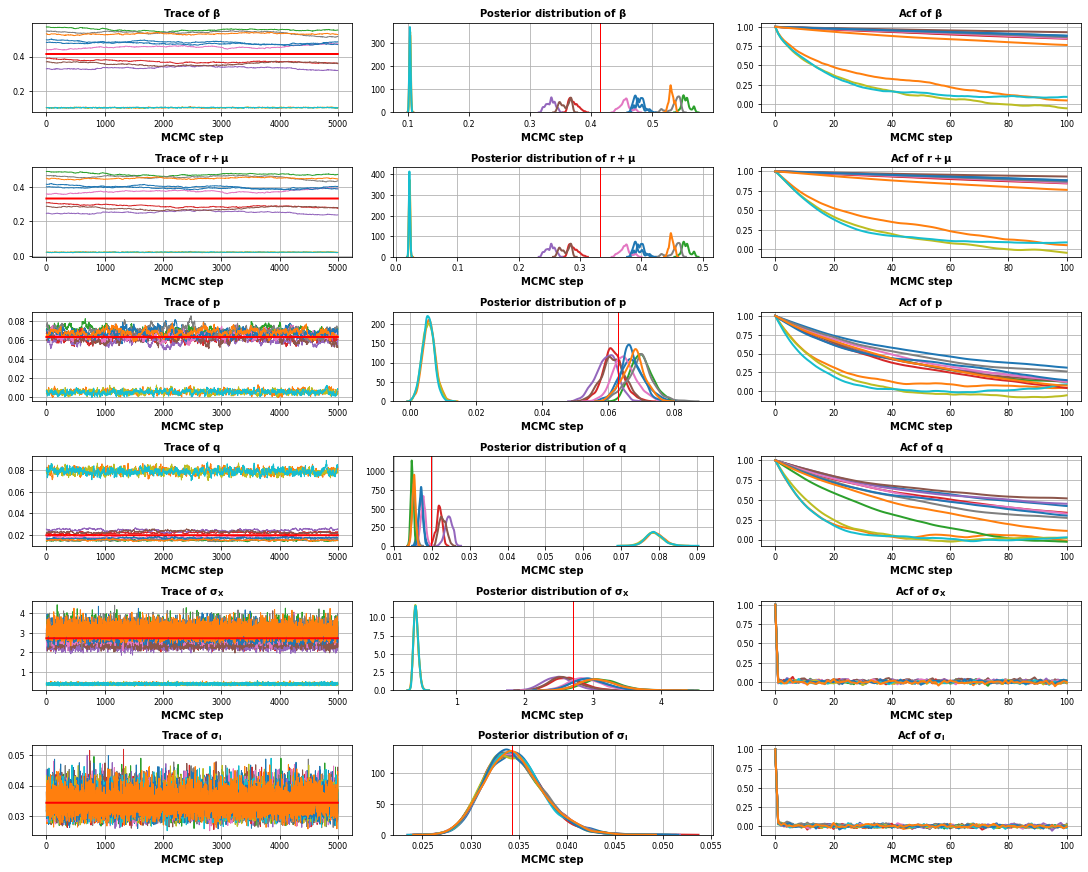

In [293]:
analysis_ita_5.plot_summary()

### Distribution of times until the number of confirmed cases falls below 1000 for the first time

469.0 29.62733958529906
CPU times: user 453 ms, sys: 15.6 ms, total: 469 ms
Wall time: 446 ms


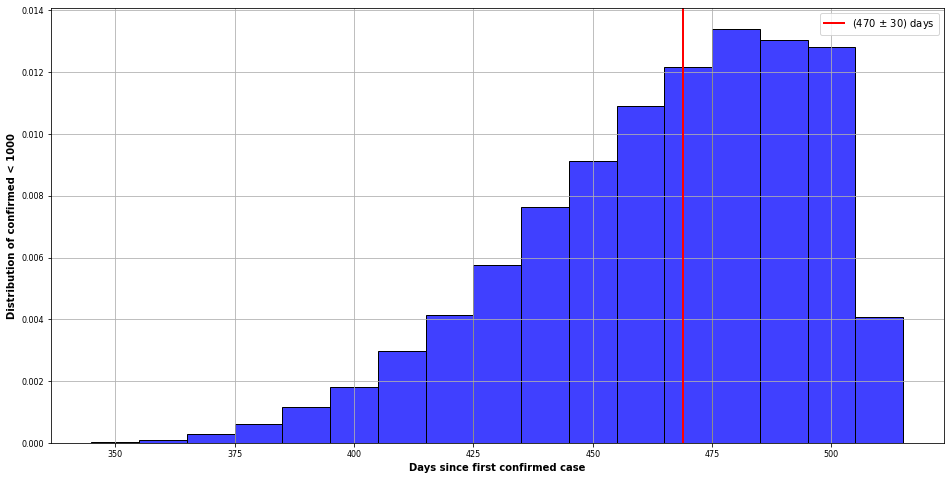

In [294]:
%%time

analysis_ita_5.end_epidemic_plot()

### Plotting fit results after peak

(4.5, 6.0)

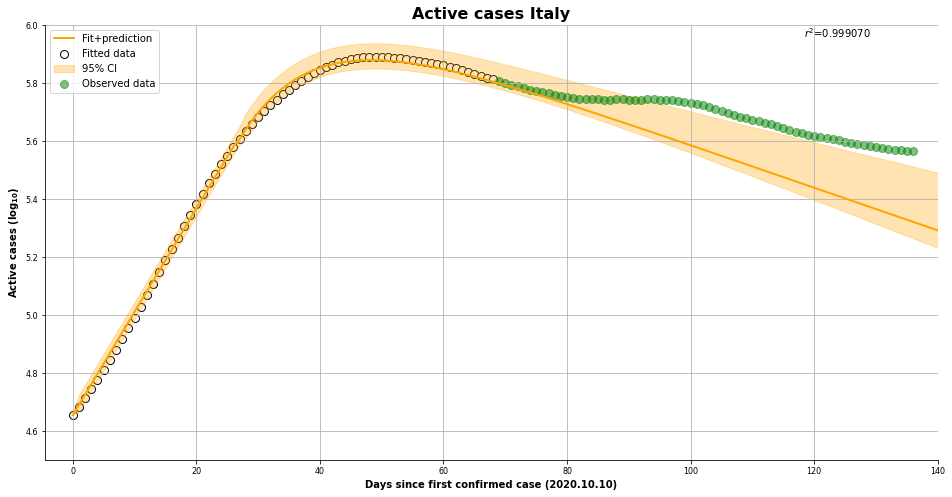

In [299]:
analysis_ita_5.plot_results(Y=True, observed=True)
plt.xlim(-4.5, 140)
plt.ylim(4.5, 6)

(2.0, 6.0)

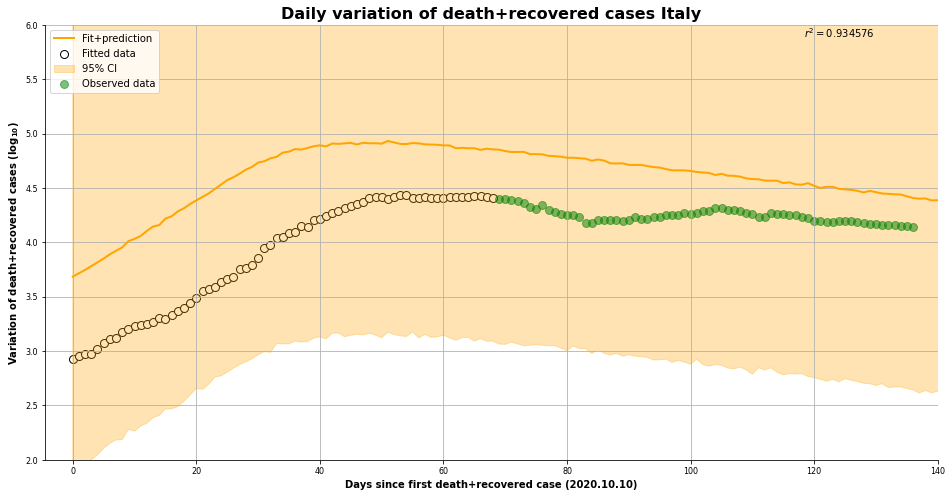

In [296]:
analysis_ita_5.plot_results(Z=True, observed=True)
plt.xlim(-4.5, 140)
plt.ylim(2, 6)

# References

1. articolo: https://arxiv.org/abs/2004.08842
    1. article [repository](https://github.com/mariocastro73/predictability)
    2. ref [5](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7190554/) 
    
2. sito Ministero della salute Spagnolo: https://www.mscbs.gob.es/
3. JAGS: https://web.sgh.waw.pl/~atoroj/ekonometria_bayesowska/jags_user_manual.pdf
4. pyJAGS: https://github.com/michaelnowotny/pyjags
5. Dati COVID-19 Italia (Protezione Civile): https://github.com/pcm-dpc/COVID-19
6. Data officially reported by Spanish Ministry of Health and curated by DATADISTA: 
<br> https://github.com/datadista/datasets/tree/master/COVID%2019/old_series
7. Updated Datasets (post-peak data), officially reported by Spanish Ministry of Health and curated by El-Pais-Data by late July, 2020:  
https://www.epdata.es/datos/coronavirus-china-datos-graficos/498

8. How to [scrape](https://medium.com/@sateesh.gmc/how-to-scrape-wikipedia-table-using-python-beautiful-soup-cd0d8ee1a319) wikipedia (non usato perché si può fare con la libreria wikipedia, ma da jupyter non sembra funzionare, solo da terminale)
* Da consultare per motivare il doubling time
    * [Plotting1](https://scipython.com/blog/plotting-covid-19-case-growth-charts/) COVID-19 case growth
    * [Plotting2](https://scipython.com/blog/plotting-covid-19-case-growth-charts/) COVID-19 case growth
    [github](https://github.com/xnx/covid-19)
